## Summary note of the phonon olympics entry for AlN

- **Author**: Terumasa TADANO (NIMS)
- **Date**: Feb. 28, 2023.
- **Codes**: VASP 6.2.1 + ALAMODE 1.4.2 (some new features of dev branch are also tested)
- **Compilers**: Intel Compiler version 20.0.2.254 + Intel MKL
- **Compile flags**: `-O2` for ALAMODE, `-O2 -xHOST` for VASP
- **MPI library**: HPE MPI 2.21
- **Computer Resource**: NIMS simulator (Intel Xeon Platinum 8268 24core 2.9 GHz x 2 / node)

In [1]:
from pymatgen.io.vasp.outputs import Vasprun, Procar, Outcar

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib as mpl

import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.set_option('display.max_rows', 100)

params = {'backend': 'ps',
          'text.latex.preamble': ['\\usepackage{gensymb}'],
          'axes.labelsize': 22, # fontsize for x and y labels (was 10)
          'axes.titlesize': 10,
          'font.size': 11, # was 10
          'legend.fontsize': 6, # was 10
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': False,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial'
}

mpl.rcParams.update(params)

In [2]:
font = Font(size=14, name='Calibri')

def write_dataframe_to_excel(ws, pd, irow = 1, icol = 1, adjust_width=True):
    
    rows = dataframe_to_rows(pd, index=False, header=True)
    
    for row_no, row in enumerate(rows, irow):
        for col_no, value in enumerate(row, icol):
            ws.cell(row=row_no, column=col_no, value=value).font = font
            
    if adjust_width:
        for col in ws.columns:
            max_length = 0
            column = col[0].column

            for cell in col:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
                
            adjusted_width = (max_length + 2)
            ws.column_dimensions[get_column_letter(column)].width = adjusted_width

In [713]:
# Reference in-plane lattice constant
encut_range = np.arange(200, 1001, 50)

vasp_encut = pd.DataFrame()
vasp_kmesh = pd.DataFrame()

corehours_list = []
aval_list = []
cval_list = []
uval_list = []
final_e_list = []


for encut in encut_range:
    vasprun = Vasprun('1.Structure/convergence_check/vasprun_ENCUT%d.k=12.xml' % (encut))
    outcar = Outcar('1.Structure/convergence_check/OUTCAR.ENCUT%d.k=12' % (encut))
    corehours = float(outcar.run_stats['cores']) * float(outcar.run_stats['Elapsed time (sec)'])/3600
    aval_list.append(vasprun.final_structure.lattice.matrix[0,0])
    cval_list.append(vasprun.final_structure.lattice.matrix[2,2])
    uval_list.append(vasprun.final_structure.frac_coords[3, 2] - vasprun.final_structure.frac_coords[1, 2])
    final_e_list.append(vasprun.final_energy)
    corehours_list.append(corehours)

vasp_encut['ENCUT (eV)'] = encut_range
vasp_encut['a (Angstrom)'] = aval_list
vasp_encut['c (Angstrom)'] = cval_list
vasp_encut['u (reduced)'] = uval_list
vasp_encut['Final energy (eV)'] = final_e_list
vasp_encut['Core Hours'] = corehours_list

kmesh_list = []
kpoint_list = []
corehours_list = []
aval_list = []
cval_list = []
uval_list = []
final_e_list = []

kmesh_range = np.arange(5, 21, 1)
for kmesh in kmesh_range:
    kmesh_z = int(kmesh / 1.6 + 0.5)
    vasprun = Vasprun('1.Structure/convergence_check/vasprun_ENCUT550.k=%d.xml' % kmesh)
    outcar = Outcar('1.Structure/convergence_check/OUTCAR.ENCUT550.k=%d' % (kmesh))
    corehours = float(outcar.run_stats['cores']) * float(outcar.run_stats['Elapsed time (sec)'])/3600
    kmesh_list.append('%sx%sx%s' % (kmesh, kmesh, kmesh_z))
    kpoint_list.append(kmesh**2*kmesh_z)
    aval_list.append(vasprun.final_structure.lattice.matrix[0,0])
    cval_list.append(vasprun.final_structure.lattice.matrix[2,2])
    uval_list.append(vasprun.final_structure.frac_coords[3, 2] - vasprun.final_structure.frac_coords[1, 2])
    final_e_list.append(vasprun.final_energy)
    corehours_list.append(corehours)

vasp_kmesh['kmesh'] = kmesh_list
vasp_kmesh['kpoints'] = kpoint_list
vasp_kmesh['a (Angstrom)'] = aval_list
vasp_kmesh['c (Angstrom)'] = cval_list
vasp_kmesh['u (reduced)'] = uval_list
vasp_kmesh['Final energy (eV)'] = final_e_list
vasp_kmesh['Core Hours'] = corehours_list



## 1. Structure - summary

The calculations were performed using `VASP` code with the following input parameters:
```
 PREC = Accurate
 ENCUT = 550
 EDIFF = 1.0e-8
 EDIFFG = -0.5e-3
 ISMEAR = 0
 SIGMA = 0.05
 ALGO= Normal
 LREAL = .FALSE.
 ADDGRID = .TRUE.
 LWAVE = .FALSE.
 LCHARG = .FALSE.
 ICHARG= 2
 ISTART=0
 NELM=200

 NPAR = 12
 KPAR = 4
 ISIF = 3
 IBRION = 1
 NSW = 100
 POTIM = 0.1

 GGA = PS
 LAPSH = .True.
 ```

As shown in the tables and figures below, the lattice constants appear to reach convergence at the 12x12x8 k points and `ENCUT=550`. 

- **ENCUT = 550**
- **12x12x8 k points for primitive**
- **a = 3.114 Angstrom**
- **c = 4.983 Angstrom**
- **u = 0.382**

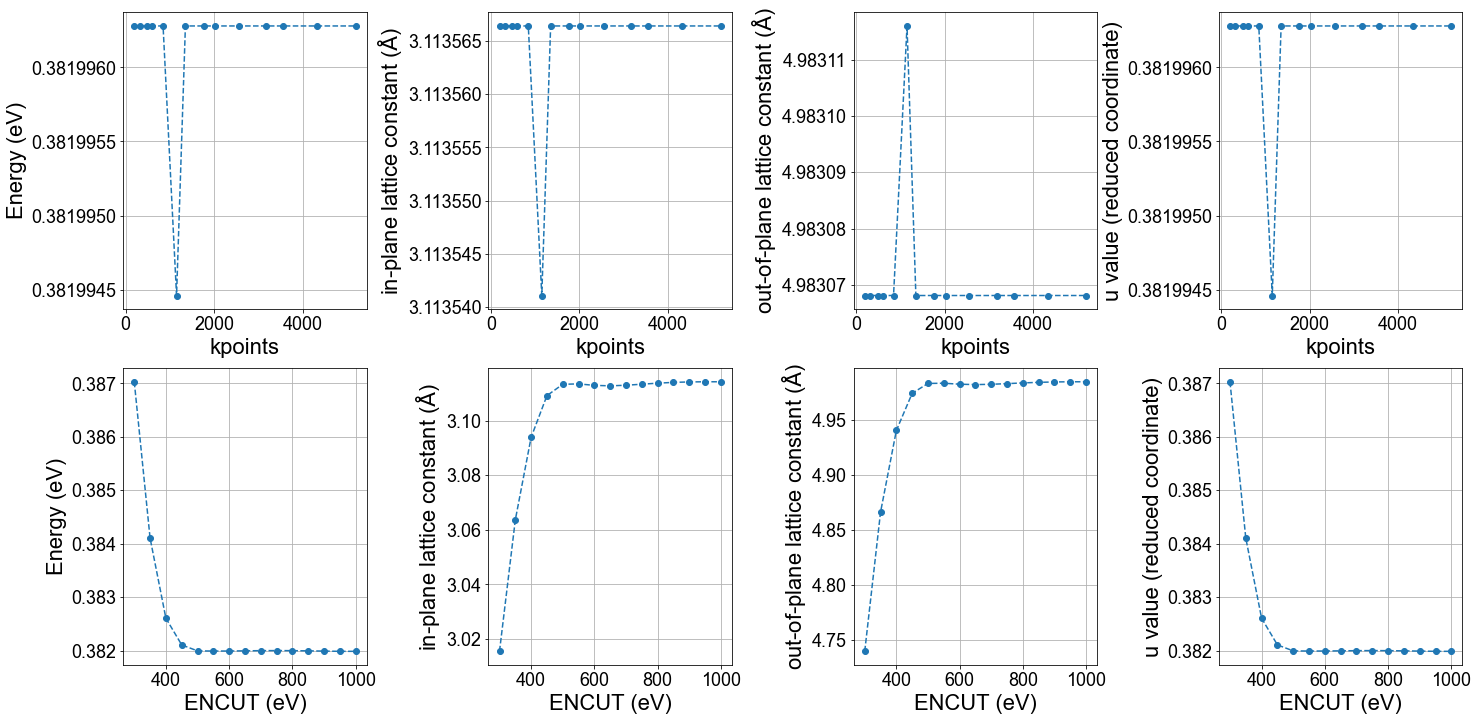

In [717]:
%matplotlib inline
# Plot figure below
fig = plt.figure(figsize=(24,12))

nrows = 2; ncols = 4
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.2, wspace=0.5)

ax = plt.subplot(gs[0,0])
vasp_kmesh[2:].plot(x=1,y=4,kind='line', ylabel='Energy (eV)', marker='o', linestyle='--', ax=ax, legend=False)
ax.grid(True)
ax.ticklabel_format(useOffset=False)

ax = plt.subplot(gs[0,1])
vasp_kmesh[2:].plot(x=1,y=2,kind='line', legend=False,
                ylabel='in-plane lattice constant ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
ax.grid(True)
ax.ticklabel_format(useOffset=False)

ax = plt.subplot(gs[0,2])
vasp_kmesh[2:].plot(x=1,y=3,kind='line', legend=False,
                ylabel='out-of-plane lattice constant ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
ax.grid(True)
ax.ticklabel_format(useOffset=False)

ax = plt.subplot(gs[0,3])
vasp_kmesh[2:].plot(x=1,y=4,kind='line', legend=False,
                ylabel='u value (reduced coordinate)', marker='o', linestyle='--', ax=ax)
ax.grid(True)
ax.ticklabel_format(useOffset=False)

ax = plt.subplot(gs[1,0])
vasp_encut[2:].plot(x=0,y=3,kind='line', legend=False,
                ylabel='Energy (eV)', marker='o', linestyle='--', ax=ax)
ax.grid(True)

ax = plt.subplot(gs[1,1])
vasp_encut[2:].plot(x=0,y=1,kind='line', legend=False,
                ylabel='in-plane lattice constant ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
ax.grid(True)

ax = plt.subplot(gs[1,2])
vasp_encut[2:].plot(x=0,y=2,kind='line', legend=False,
                ylabel='out-of-plane lattice constant ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
ax.grid(True)

ax = plt.subplot(gs[1,3])
vasp_encut[2:].plot(x=0,y=3,kind='line', legend=False,
                ylabel='u value (reduced coordinate)', marker='o', linestyle='--', ax=ax)
ax.grid(True)

plt.savefig('convergence_structure.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [546]:
# Electronic band structure

from pymatgen.electronic_structure.core import Spin, Orbital

#pathes = ['G-M', 'G-K-M']
nb = 12

bs_k12 = pd.DataFrame()
    
dosrun= Vasprun("./2.Electronic/band/vasprun_scf_k12.xml", parse_dos=True)
dos = dosrun.complete_dos
bs = Vasprun(
    "./2.Electronic/band/vasprun_band_k12.xml").get_band_structure(
    "./2.Electronic/band/KPOINTS.band", 
    efermi=dosrun.efermi, 
    line_mode=True)

bs_k12.attrs['efermi'] = dos.efermi
bs_k12.attrs['SCF'] = '(SCF 12x12x8 G-cntrd k points)'

kval = np.array(bs.distance)
data = bs.bands[Spin.up]
bs_k12['k_distance'] = kval
for ib in range(nb):
    bs_k12['E%d' % (ib+1)] = data[ib+2,:] - dos.efermi
    
    
bs_k20 = pd.DataFrame()
    
dosrun= Vasprun("./2.Electronic/band/vasprun_scf_k20.xml", parse_dos=True)
dos = dosrun.complete_dos
bs = Vasprun(
    "./2.Electronic/band/vasprun_band_k20.xml").get_band_structure(
    "./2.Electronic/band/KPOINTS.band", 
    efermi=dosrun.efermi, 
    line_mode=True)

bs_k20.attrs['efermi'] = dos.efermi
bs_k20.attrs['SCF'] = '(SCF 20x20x13 G-cntrd k points)'

kval = np.array(bs.distance)
data = bs.bands[Spin.up]
bs_k20['k_distance'] = kval
for ib in range(nb):
    bs_k20['E%d' % (ib+1)] = data[ib+2,:] - dos.efermi


## 2. Electronic - summary
The electronic band dispersion obtained from the 12x12x8 k points agrees well with the result obtained from the denser 20x20x13 k points. So, we conclude that 12x12x8 kpoints was accurate enough.

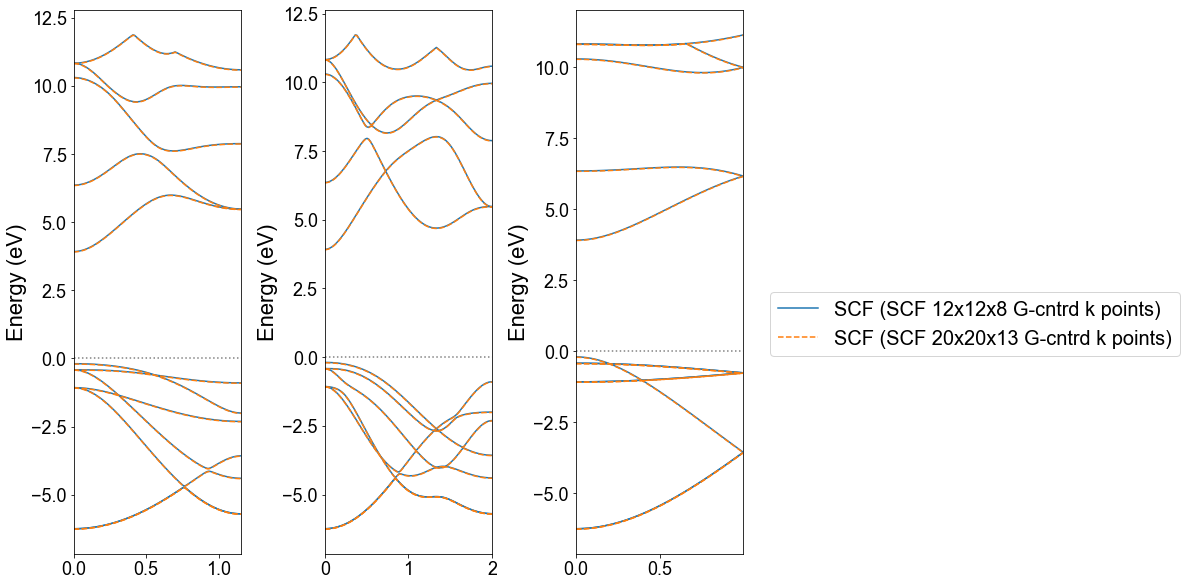

In [724]:
fig = plt.figure(figsize=(12,10))
nrows = 1
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

ranges = [[0, 100], [0, 100], [0, 100]]
labels = [['G', 'M'], ['G', 'K', 'M'], ['G', 'A']]
tickvals = [[0, 1], [0, 0.666667, 1], [0, 1]]

scaler_a = np.pi / 3.11354109266049
scaler_c = np.pi / 4.98311595690762

scalers = [scaler_a, scaler_a, scaler_c]

for iax, ra in enumerate(ranges):
    
    ax = plt.subplot(gs[iax])
    
    bs_tmp = bs_k12[100*iax:100*(iax+1)]
    ax.plot((bs_tmp['k_distance']-bs_tmp['k_distance'].iloc[0]) / scalers[iax], 
            bs_tmp['E1'], linestyle='-', 
            marker='None', color='C0', label='SCF %s' % bs_k12.attrs['SCF'])
    
    for ib in range(1, 12):
        ax.plot((bs_tmp['k_distance']-bs_tmp['k_distance'].iloc[0]) / scalers[iax], 
                bs_tmp['E%d' % ib], linestyle='-', 
                marker='None', color='C0')
        
        
    bs_tmp = bs_k20[100*iax:100*(iax+1)]
    ax.plot((bs_tmp['k_distance'] - bs_tmp['k_distance'].iloc[0]) / scalers[iax], 
            bs_tmp['E1'], linestyle='--', 
            marker='None', color='C1', label='SCF %s' % bs_k20.attrs['SCF'])
    
    for ib in range(1, 12):
        ax.plot((bs_tmp['k_distance'] - bs_tmp['k_distance'].iloc[0])/scalers[iax], 
                bs_tmp['E%d' % ib], linestyle='--', 
                marker='None', color='C1')

    ax.set_xlim(0,(bs_tmp['k_distance'].iloc[99]-bs_tmp['k_distance'].iloc[0])/scalers[iax])
    ax.set_ylabel('Energy (eV)')
    ax.axhline(y=0.0, linestyle=':', color='gray')
    if iax == 2:
        ax.legend(fontsize=20, bbox_to_anchor=(1.1, 0.5))

plt.savefig('ElectronicBandStructure.pdf', dpi=300, bbox_inches='tight')        
plt.show()

In [56]:
# 3. Harmonic calculation

encut_list = np.arange(450, 1001, 50)

kpoint_info = []
for encut in encut_list:
    vasprun_dict = Vasprun('3.Harmonic/convergence_check/vasprun_ENCUT%d.k=12_1.xml' % encut).as_dict()['input']['kpoints']
    kpoint_info.append([vasprun_dict['generation_style'],
                        vasprun_dict['kpoints'][0],
                        vasprun_dict['shift']])


summary_ph_convcheck_encut = pd.read_table('3.Harmonic/convergence_check/phonon_gamma_ENCUT.dat', usecols=[0, 5, 7, 8, 9, 11, 13],
                                        header=None, skiprows=1, delim_whitespace=True, 
                                        names=('ENCUT (eV)', 'f_G1', 'f_G2', 'f_G3', 'f_G4', 'f_G5', 'f_G6'))
list_kp = list(zip(*kpoint_info))
summary_ph_convcheck_encut['k mesh style'] = list_kp[0]
summary_ph_convcheck_encut['k mesh'] = list_kp[1]
summary_ph_convcheck_encut['k mesh shift'] = list_kp[2]


kmesh_range = np.arange(5, 21, 1)


kpoint_info = []
for kmesh in kmesh_range:
    vasprun_dict = Vasprun('3.Harmonic/convergence_check/vasprun_ENCUT550.k=%d_1.xml' % kmesh).as_dict()['input']['kpoints']
    kpoint_info.append([vasprun_dict['generation_style'],
                        vasprun_dict['kpoints'][0],
                        vasprun_dict['shift']])


summary_ph_convcheck_kmesh = pd.read_table('3.Harmonic/convergence_check/phonon_gamma_kmesh.dat', usecols=[0, 5, 7, 8, 9, 11, 13],
                                        header=None, skiprows=0, delim_whitespace=True, 
                                        names=('k1', 'f_G1', 'f_G2', 'f_G3', 'f_G4', 'f_G5', 'f_G6'))
list_kp = list(zip(*kpoint_info))
summary_ph_convcheck_kmesh['k mesh style'] = list_kp[0]
summary_ph_convcheck_kmesh['k mesh'] = list_kp[1]
summary_ph_convcheck_kmesh['k mesh shift'] = list_kp[2]


kayser_to_THz = 0.029979245800000

for mode in range(1, 7):
    summary_ph_convcheck_encut['f_G%d' % mode] *= kayser_to_THz
    summary_ph_convcheck_kmesh['f_G%d' % mode] *= kayser_to_THz

## 3.1 Harmonic - convergence at G and M points

The phonon frequencies at Gamma (0,0,0) points are calculated using the following conditions:

- primitive cell (4 atoms)
- displacement magnitude : 0.01 Angstrom
- make full use of symmetry (permutation, space group)
- consider ASR as constraint
- Fit displacement-force dataset by ordinary least squares

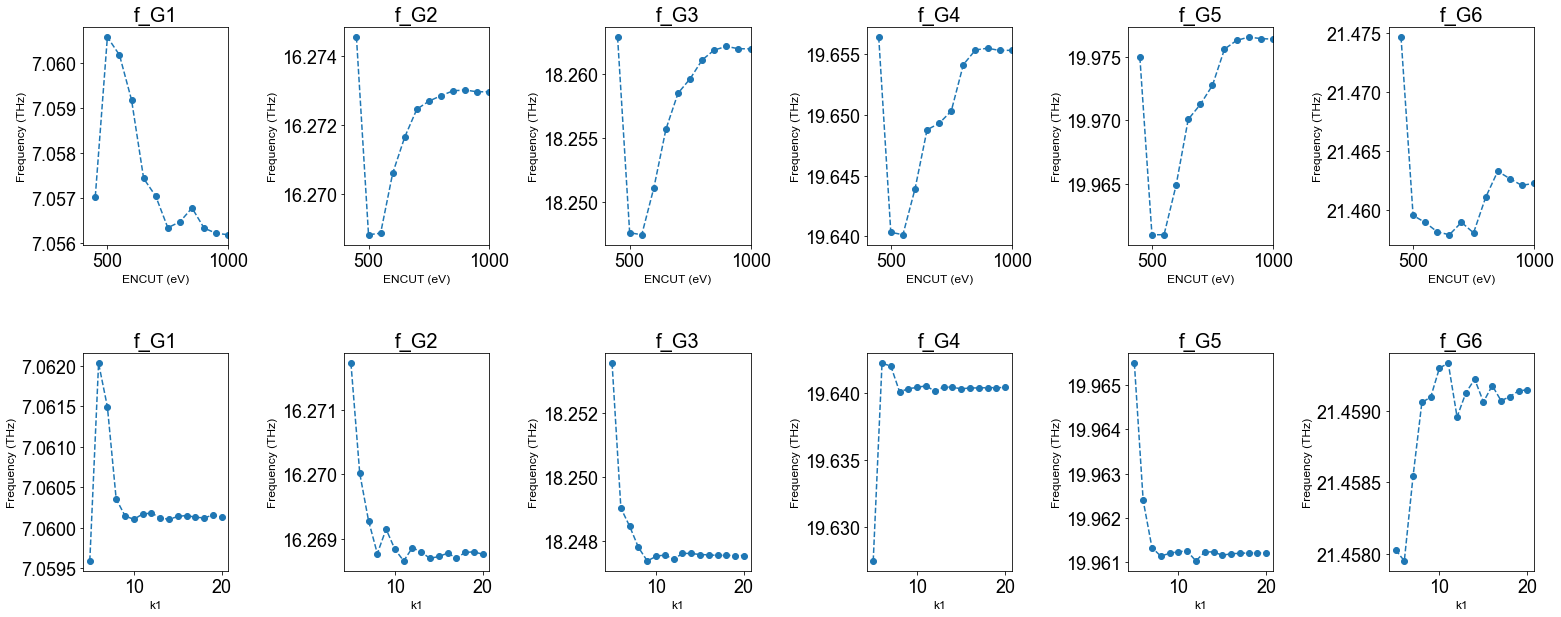

In [751]:
fig = plt.figure(figsize=(26,10))
nrows = 2
ncols = 6

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.8)

icount = 0
for icol in range(ncols):
    ax = plt.subplot(gs[0, icol])

    icount +=1

    ax.plot(summary_ph_convcheck_encut['ENCUT (eV)'], summary_ph_convcheck_encut['f_G%d' % icount] , linestyle='--', marker='o')
    ax.set_title('f_G%d' % icount, fontsize=20)
    ax.set_xlim(400,1000)
    ax.set_xlabel('ENCUT (eV)', fontsize=12)
    ax.set_ylabel('Frequency (THz)', fontsize=12)
        
icount = 0        
for icol in range(ncols):
    ax = plt.subplot(gs[1, icol])

    icount +=1

    ax.plot(summary_ph_convcheck_kmesh['k1'], summary_ph_convcheck_kmesh['f_G%d' % icount] , linestyle='--', marker='o')
    ax.set_title('f_G%d' % icount, fontsize=20)
#    ax.set_xlim(400,1000)
    ax.set_xlabel('k1', fontsize=12)
    ax.set_ylabel('Frequency (THz)', fontsize=12)
    ax.ticklabel_format(useOffset=False)

plt.savefig('convergence_frequency_gamma.pdf', bbox_inches='tight')
plt.show()

In [856]:
import glob

supercells = ['convergence_check', 'super222.displace', 'super332.displace', 'super442.displace', 'super443.displace']
supercell_labels = ['111', '222', '332', '442', '443']

data = [['Supercell (SC) size', 
        '# atoms in SC', 
        'ENCUT',
        'k mesh style', 'k mesh', 'k mesh shift',
        'Core hours',
        'magnitude of\ndisplacement (Ang.)']]

dispmag = 0.01

for i, sc in enumerate(supercells):
    core_hours = 0.0
    
    
    if i == 0:
        outcars = glob.glob("3.Harmonic/%s/OUTCAR.ENCUT550.k=12.disp*" % sc)
        vasprun = Vasprun("3.Harmonic/%s/vasprun_ENCUT550.k=12_1.xml" % sc)
    else:
        outcars = glob.glob("3.Harmonic/%s/OUTCAR.disp*" % sc)
        vasprun = Vasprun("3.Harmonic/%s/vasprun_disp01.xml" % sc)

    for outcar_file in outcars:
        outcar = Outcar(outcar_file)
        core_hours += float(outcar.run_stats['cores']) * float(outcar.run_stats['Elapsed time (sec)'])/3600
    
    vasprun_dict = vasprun.as_dict()
    data.append([supercell_labels[i],
                 vasprun_dict['nsites'],
                 vasprun_dict['input']['incar']['ENCUT'],
                 vasprun_dict['input']['kpoints']['generation_style'],
                 str(vasprun_dict['input']['kpoints']['kpoints'][0]),
                 str(vasprun_dict['input']['kpoints']['shift']),
                 core_hours, dispmag])
    
summary_phband_settings = pd.DataFrame(data[1:], columns=data[0])
phband_data = []

header=['q']
for i in range(1, 12):
    header.append('f%d' %i)
pathes = ['G-M', 'G-K-M', 'G-A']

ranges = [[0, 100], [100, 200], [200, 300]]
labels = [['G', 'M'], ['G', 'K', 'M'], ['G', 'A']]
tickvals = [[0.000000, 0.616546],  [0.616546, 1.328473, 1.684436], [1.684436, 2.018055]]

kayser_to_THz = 0.0299792458

for i, sc in enumerate(supercells):
    
    phband_data_now = []
    scname = supercell_labels[i]
    phband = np.loadtxt('3.Harmonic/%s/super%s.bands' % (sc, scname))
    nbands = len(phband[0,:]) - 1

    for j, path in enumerate(pathes):
        
        pd_tmp = pd.DataFrame()
        pd_tmp.attrs['SC'] = supercell_labels[i]
        nrows = ranges[j][1]-ranges[j][0]
        data = np.zeros((nrows, 13))
        data[:,0] = (phband[ranges[j][0]:ranges[j][1],0]-phband[ranges[j][0],0])
        pd_tmp['q (original)'] = data[:,0]
        data[:,0] /= data[-1,0]
        data[:,1:] = phband[ranges[j][0]:ranges[j][1],1:13]
        data[:,1:] *= kayser_to_THz
        
        pd_tmp['q (normalized)'] = data[:,0]
        for k in range(1, 13):
            pd_tmp['f%d' % k] = data[:,k]
        pd_tmp.attrs['line'] = path
        phband_data_now.append(pd_tmp)
    
    phband_data.append(phband_data_now)


## 3.2 Harmonic - convergence of dispersion

To examine the convergence of phonon dispersion curves, we have performed phonon calculations using various supercells and k points as summarized below:

In [596]:
summary_phband_settings

,Supercell (SC) size,# atoms in SC,ENCUT,k mesh style,k mesh,k mesh shift,Core hours,magnitude of\ndisplacement (Ang.)
0,111,4,550.0,Gamma,"[12, 12, 8]","[0.0, 0.0, 0.0]",1.441013,0.01
1,222,32,550.0,Gamma,"[6, 6, 4]","[0.0, 0.0, 0.0]",17.772160,0.01
2,332,72,550.0,Gamma,"[4, 4, 4]","[0.0, 0.0, 0.0]",48.105067,0.01
3,442,128,550.0,Gamma,"[3, 3, 4]","[0.0, 0.0, 0.0]",128.332427,0.01
4,443,192,550.0,Gamma,"[3, 3, 3]","[0.0, 0.0, 0.0]",233.681227,0.01


The results are plotted in the **figure below.**

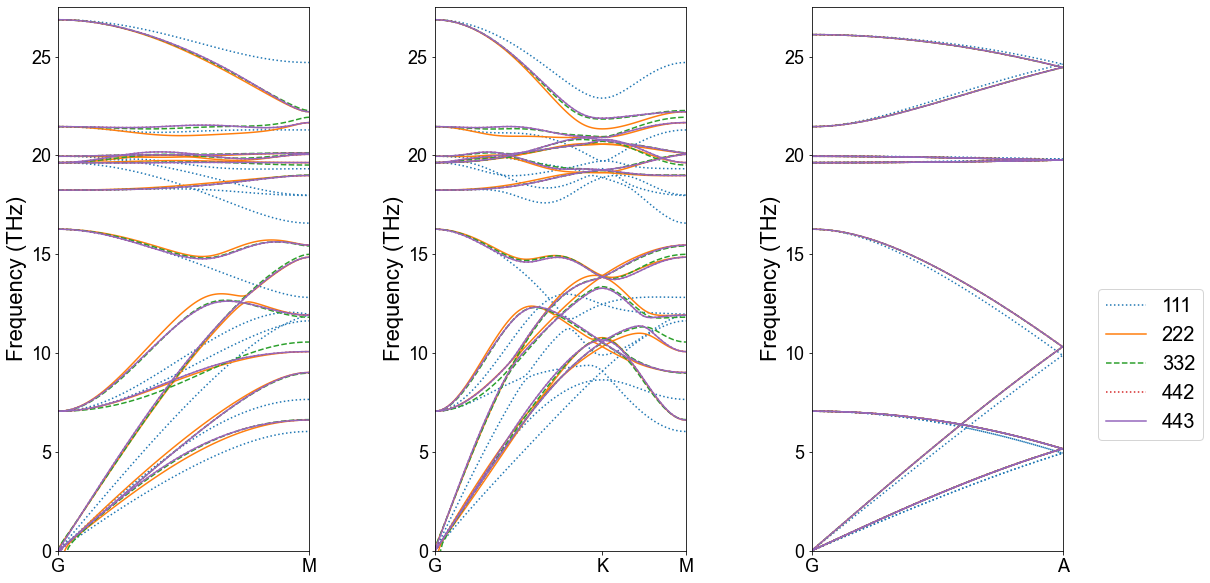

In [595]:
fig = plt.figure(figsize=(18,10))
nrows = 1
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

tickvals = [[0, 1], [0, 0.666667, 1], [0, 1]]

cl = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
ls = [':', '-', '--']

for iax, ra in enumerate(ranges):
    ax = plt.subplot(gs[iax])

    for i, sc in enumerate(supercells):
        scname = supercell_labels[i]
        phband2 = phband_data[i][iax]
   
        ax.plot(phband2['q (normalized)'], phband2['f1'],
                linestyle=ls[i%3],
                marker='None',
                color=cl[i%7], 
                label=scname)

        for ib in range(1,12):
            ax.plot(phband2['q (normalized)'], phband2['f%d' % (ib + 1)],
                    linestyle=ls[i%3],
                    marker='None',
                    color=cl[i%7]) 

        ax.set_ylim(0, 27.5)
        xmin = tickvals[iax][0]
        xmax = tickvals[iax][-1]
        tickvals[iax][:]= (np.array(tickvals[iax][:])-xmin)/(xmax-xmin)
        ax.set_xlim(tickvals[iax][0], tickvals[iax][-1])
        ax.set_xticklabels(labels[iax])
        ax.set_xticks(tickvals[iax])
        ax.set_ylabel('Frequency (THz)')
    if iax == 2:
        ax.legend(fontsize=20, bbox_to_anchor=(1.1, 0.5))

plt.savefig('PhononBandStructure.pdf', dpi=300, bbox_inches='tight')        
plt.show()

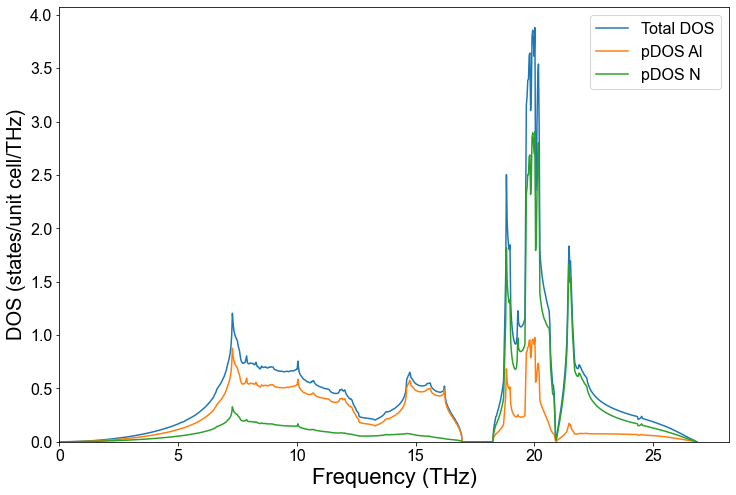

In [911]:
phdos = pd.read_table('3.Harmonic/super443.displace/supercell_NA3.dos', comment='#',
                       header=None, names=['Omega (cm^-1)', 'Total DOS', 'pDOS Al1', 'pDOS Al2', 'pDOS N1', 'pDOS N2'],
                             delim_whitespace=True)

phdos['Omega (cm^-1)'] *= kayser_to_THz
phdos['Total DOS'] /= kayser_to_THz
phdos['pDOS Al (states/unit cell/THz)'] = (phdos['pDOS Al1'] + phdos['pDOS Al2']) / kayser_to_THz
phdos['pDOS N (states/unit cell/THz)'] = (phdos['pDOS N1'] + phdos['pDOS N2']) / kayser_to_THz

phdos.rename(columns={'Omega (cm^-1)': 'Frequency (THz)', 'Total DOS' : 'Total DOS (states/unit cell/THz)'}, inplace=True)

del phdos['pDOS Al1']
del phdos['pDOS Al2']
del phdos['pDOS N1']
del phdos['pDOS N2']

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
phdos.plot(x=0, y=1, label='Total DOS', fontsize=16, ax=ax)
phdos.plot(x=0, y=2, label='pDOS Al', fontsize=16, ax=ax)
phdos.plot(x=0, y=3, label='pDOS N', fontsize=16, ax=ax)

ax.set_xlim(0)
ax.set_ylim(0)
ax.set_ylabel('DOS (states/unit cell/THz)', fontsize=20)
ax.legend(loc='best', fontsize=16)

In [433]:
import glob
import os

def get_kappa_from_file(fname, temperature):
    retval = None
    with open(fname, 'r') as f:
        for line in f.readlines():
            if str(temperature) in line:
                if float(line.strip().split()[0]) == temperature:
                    retval = [float(line.strip().split()[1]), float(line.strip().split()[-1])]
                    break
    return retval

def get_num_displacements(fname):
    retval = None
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "Number of disp. patterns for   ANHARM3" in line:
                retval = int(line.strip().split(':')[1])
                break
    return retval


def get_num_irred_ifc3(fname):
    retval = None
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "Number of free  ANHARM3 FCs" in line:
                retval = int(line.strip().split(':')[1])
                break
    return retval


def get_nodehour_vasp(dirname):
    outcars = glob.glob("%s/*.OUTCAR" % dirname)
    
    retval = []
    
    nodehours = 0.0
    ncores_per_node = 48
    
    for outcar in outcars:
        obj = Outcar(outcar).as_dict()
        retval.append([obj['run_stats']['cores'],
                       obj['run_stats']['Total CPU time used (sec)'],
                       obj['run_stats']['Elapsed time (sec)']])
        
        nodehours += (int(obj['run_stats']['cores']) // ncores_per_node) \
                     * obj['run_stats']['Elapsed time (sec)']
        
    return nodehours / float(3600), retval


def get_nodehour_vasp2(dirname, regex):
    outcars = glob.glob("%s/%s" % (dirname, regex))
    
    retval = []
    
    nodehours = 0.0
    ncores_per_node = 48
    
    for outcar in outcars:
        obj = Outcar(outcar).as_dict()
        retval.append([obj['run_stats']['cores'],
                       obj['run_stats']['Total CPU time used (sec)'],
                       obj['run_stats']['Elapsed time (sec)']])
        
        nodehours += (int(obj['run_stats']['cores']) // ncores_per_node) \
                     * obj['run_stats']['Elapsed time (sec)']
        
    return nodehours / float(3600), retval

def get_corehours_vasp(outcar):

    corehours = 0.0
    
    obj = Outcar(outcar).as_dict()
    corehours = float(obj['run_stats']['cores']) * obj['run_stats']['Elapsed time (sec)'] / 3600.0
        
    return corehours


In [452]:
#sheet = wb.create_sheet(title='4.Anharmonic (VASP, conv. check)')

temperature = 300
# Scaling factor computed from the layer thickness

kappa_332 = []
ndisp_332 = []
nifc3_332 = []

nnlist = np.arange(1, 21, 1)

nodehour_vasp_332 = []

rcinfo1 = np.loadtxt('4.Anharmonic/super332.displace/ols/nninfo.txt', usecols=[1,])
nodehour = 0.0

kappa_all_list = []
kappa_all_list_mic1 = []

sc_size_ifc2 = '443'
sc_size_ifc3 = '332'
kmesh = 24
qmesh = '24 24 16'
nodehour, _ = get_nodehour_vasp('VASP/4.Anharmonic/super332.displace/')
corehour = 48 * nodehour

for i, nn in enumerate(nnlist):
    for ntraining in range(10, 501, 10):
        fname1 = '4.Anharmonic/super332.displace/ols/cubic_%dnn_ndata%d_ols.kl' % (nn, ntraining)
        fname2 = '4.Anharmonic/super332.displace/ols/cubic_%dnn_ndata%d_ols_mic1.kl' % (nn, ntraining)
        fname3 = '4.Anharmonic/super332.displace/ols/ols_%d_%d.log' % (nn, ntraining)
        fname4 = '4.Anharmonic/super332.displace/ols/ols_%d_%d.log2' % (nn, ntraining)


        if os.path.exists(fname1) and os.path.exists(fname3):
            kappa_tmp1 = get_kappa_from_file(fname1, temperature)
            nifc3_tmp1 = get_num_irred_ifc3(fname3)

            rcval = rcinfo1[i]

            kappa_all_list.append([sc_size_ifc2, 
                                   sc_size_ifc3, 
                                   rcval,
                                   nn,
                                   ntraining,
                                   nifc3_tmp1,
                                   kappa_tmp1[0],
                                   kappa_tmp1[1],
                                   qmesh,
                                   corehour])

        if os.path.exists(fname2) and os.path.exists(fname4):
            kappa_tmp1 = get_kappa_from_file(fname2, temperature)
            nifc3_tmp1 = get_num_irred_ifc3(fname4)

            rcval = rcinfo1[i]

            kappa_all_list_mic1.append([sc_size_ifc2, 
                                        sc_size_ifc3, 
                                        rcval,
                                        nn,
                                        ntraining,
                                        nifc3_tmp1,
                                        kappa_tmp1[0],
                                        kappa_tmp1[1],
                                        qmesh,
                                        corehour])

kappa_all = pd.DataFrame(kappa_all_list, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

kappa_all_mic1 = pd.DataFrame(kappa_all_list_mic1, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])
# Add node hour information of kappa part to the dataframe
#time_661 = np.loadtxt('VASP/4.Anharmonic/661/summary_kappa.dat', usecols=[0, 4, 5])

#corehour_anphon_661 = time_661[:,1] * time_661[:,2] / 3600.0

#kappa_all['Core hours (kappa)'] = corehour_anphon_661

In [451]:
temperature = 300
kappa_scale = 1

kappa_332 = []
ndisp_332 = []
nifc3_332 = []

nnlist = np.arange(1, 21, 1)

nodehour_vasp_332 = []

rcinfo1 = np.loadtxt('4.Anharmonic/super332.displace/ols/nninfo.txt', usecols=[1,])
nodehour = 0.0

kappa_all_list_kmesh13 = []
kappa_all_list_kmesh13_mic1 = []

sc_size_ifc2 = '443'
sc_size_ifc3 = '332'
kmesh = 13
qmesh = '13 13 9'
#ntraining = 200
nodehour, _ = get_nodehour_vasp('VASP/4.Anharmonic/super332.displace/')
corehour = 48 * nodehour

for i, nn in enumerate(nnlist):
    for ntraining in range(10, 501, 10):
        fname1 = '4.Anharmonic/super332.displace/ols/cubic_%dnn_ndata%d_ols_kmesh13.kl' % (nn, ntraining)
        fname2 = '4.Anharmonic/super332.displace/ols/cubic_%dnn_ndata%d_ols_kmesh13_mic1.kl' % (nn, ntraining)
        fname3 = '4.Anharmonic/super332.displace/ols/ols_%d_%d.log' % (nn, ntraining)
        fname4 = '4.Anharmonic/super332.displace/ols/ols_%d_%d.log2' % (nn, ntraining)


        if os.path.exists(fname1) and os.path.exists(fname3):
            kappa_tmp1 = get_kappa_from_file(fname1, temperature) * kappa_scale
            nifc3_tmp1 = get_num_irred_ifc3(fname3)

            rcval = rcinfo1[i]

            kappa_all_list_kmesh13.append([sc_size_ifc2, 
                                   sc_size_ifc3, 
                                   rcval,
                                   nn,
                                   ntraining,
                                   nifc3_tmp1,
                                   kappa_tmp1[0],
                                   kappa_tmp1[1],
                                   qmesh,
                                   corehour])

        if os.path.exists(fname2) and os.path.exists(fname4):
            kappa_tmp1 = get_kappa_from_file(fname2, temperature) * kappa_scale
            nifc3_tmp1 = get_num_irred_ifc3(fname4)

            rcval = rcinfo1[i]

            kappa_all_list_kmesh13_mic1.append([sc_size_ifc2, 
                                        sc_size_ifc3, 
                                        rcval,
                                        nn,
                                        ntraining,
                                        nifc3_tmp1,
                                        kappa_tmp1[0],
                                        kappa_tmp1[1],
                                        qmesh,
                                        corehour])

kappa_kmesh13 = pd.DataFrame(kappa_all_list_kmesh13, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

kappa_kmesh13_mic1 = pd.DataFrame(kappa_all_list_kmesh13_mic1, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

In [450]:
temperature = 300
kappa_scale = 1

kappa_332 = []
ndisp_332 = []
nifc3_332 = []

nnlist = np.arange(1, 21, 1)

nodehour_vasp_332 = []

rcinfo1 = np.loadtxt('4.Anharmonic/super443.displace/ols/nninfo.txt', usecols=[1,])
nodehour = 0.0

kappa_all_list_kmesh13 = []
kappa_all_list_kmesh13_mic1 = []

sc_size_ifc2 = '443'
sc_size_ifc3 = '443'
kmesh = 13
qmesh = '13 13 9'
#ntraining = 200
nodehour, _ = get_nodehour_vasp('VASP/4.Anharmonic/super443.displace/')
corehour = 48 * nodehour

for i, nn in enumerate(nnlist):
    for ntraining in range(10, 201, 10):
        fname1 = '4.Anharmonic/super443.displace/ols/cubic_%dnn_ndata%d_ols_kmesh13.kl' % (nn, ntraining)
        fname2 = '4.Anharmonic/super443.displace/ols/cubic_%dnn_ndata%d_ols_kmesh13_mic1.kl' % (nn, ntraining)
        fname3 = '4.Anharmonic/super443.displace/ols/ols_%d_%d.log' % (nn, ntraining)
        fname4 = '4.Anharmonic/super443.displace/ols/ols_%d_%d.log2' % (nn, ntraining)


        if os.path.exists(fname1) and os.path.exists(fname3):
            kappa_tmp1 = get_kappa_from_file(fname1, temperature) * kappa_scale
            nifc3_tmp1 = get_num_irred_ifc3(fname3)

            rcval = rcinfo1[i]

            kappa_all_list_kmesh13.append([sc_size_ifc2, 
                                   sc_size_ifc3, 
                                   rcval,
                                   nn,
                                   ntraining,
                                   nifc3_tmp1,
                                   kappa_tmp1[0],
                                   kappa_tmp1[1],
                                   qmesh,
                                   corehour])

        if os.path.exists(fname2) and os.path.exists(fname4):
            kappa_tmp1 = get_kappa_from_file(fname2, temperature) * kappa_scale
            nifc3_tmp1 = get_num_irred_ifc3(fname4)

            rcval = rcinfo1[i]

            kappa_all_list_kmesh13_mic1.append([sc_size_ifc2, 
                                        sc_size_ifc3, 
                                        rcval,
                                        nn,
                                        ntraining,
                                        nifc3_tmp1,
                                        kappa_tmp1[0],
                                        kappa_tmp1[1],
                                        qmesh,
                                        corehour])

kappa_kmesh13_sc443 = pd.DataFrame(kappa_all_list_kmesh13, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

# kappa_kmesh13_mic1 = pd.DataFrame(kappa_all_list_kmesh13_mic1, 
#                          columns=['SC size IFC2', 'SC size IFC3', 
#                                   'Cutoff radius for IFC3 (bohr)',
#                                   'nn shell',
#                                   '# disp. patterns.',
#                                   '# irred. IFC3', 
#                                   'kappa_{RTA,pure} (W/mK)',
#                                   'qmesh',
#                                   'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
#                                                                         'SC size IFC3'])

In [449]:
temperature = 300
kappa_scale = 1

kappa_332 = []
ndisp_332 = []
nifc3_332 = []

nnlist = np.arange(1, 21, 1)

nodehour_vasp_332 = []

rcinfo1 = np.loadtxt('4.Anharmonic/super332.displace/ols/nninfo.txt', usecols=[1,])
nodehour = 0.0

kappa_all_list_kmesh13_lasso_mic1 = []
kappa_all_list_kmesh13_adalasso_mic1 = []

sc_size_ifc2 = '443'
sc_size_ifc3 = '332'
kmesh = 13
qmesh = '13 13 9'
#ntraining = 200
nodehour, _ = get_nodehour_vasp('VASP/4.Anharmonic/super332.displace/')
corehour = 48 * nodehour

for i, nn in enumerate(nnlist):
    for ntraining in range(10, 301, 10):
        fname1 = '4.Anharmonic/super332.displace/lasso/cubic_%dnn_ndata%d_lasso_kmesh13_mic1.kl' % (nn, ntraining)
        fname2 = '4.Anharmonic/super332.displace/lasso/cubic_%dnn_ndata%d_adalasso_kmesh13_mic1.kl' % (nn, ntraining)
        fname3 = '4.Anharmonic/super332.displace/lasso/lasso_%d_%d.log2' % (nn, ntraining)
        fname4 = '4.Anharmonic/super332.displace/lasso/adalasso_%d_%d.log2' % (nn, ntraining)


        if os.path.exists(fname1) and os.path.exists(fname3):
            kappa_tmp1 = get_kappa_from_file(fname1, temperature) * kappa_scale
            nifc3_tmp1 = get_num_irred_ifc3(fname3)

            rcval = rcinfo1[i]

            kappa_all_list_kmesh13_lasso_mic1.append([sc_size_ifc2, 
                                   sc_size_ifc3, 
                                   rcval,
                                   nn,
                                   ntraining,
                                   nifc3_tmp1,
                                   kappa_tmp1[0],
                                   kappa_tmp1[1],
                                   qmesh,
                                   corehour])

        if os.path.exists(fname2) and os.path.exists(fname4):
            kappa_tmp1 = get_kappa_from_file(fname2, temperature) * kappa_scale
            nifc3_tmp1 = get_num_irred_ifc3(fname4)

            rcval = rcinfo1[i]

            kappa_all_list_kmesh13_adalasso_mic1.append([sc_size_ifc2, 
                                        sc_size_ifc3, 
                                        rcval,
                                        nn,
                                        ntraining,
                                        nifc3_tmp1,
                                        kappa_tmp1[0],
                                        kappa_tmp1[1],
                                        qmesh,
                                        corehour])

kappa_kmesh13_lasso_mic1 = pd.DataFrame(kappa_all_list_kmesh13_lasso_mic1, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

kappa_kmesh13_adalasso_mic1 = pd.DataFrame(kappa_all_list_kmesh13_adalasso_mic1, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

In [522]:
temperature = 300
kappa_scale = 1

kappa_332 = []
ndisp_332 = []
nifc3_332 = []

nnlist = np.arange(1, 21, 1)

nodehour_vasp_332 = []

rcinfo1 = np.loadtxt('4.Anharmonic/super332.displace/ols/nninfo.txt', usecols=[1,])
nodehour = 0.0

kappa_all_list_kmesh13_sc443_lasso = []
kappa_all_list_kmesh13_sc443_adalasso = []

sc_size_ifc2 = '443'
sc_size_ifc3 = '443'
kmesh = 13
qmesh = '13 13 9'
#ntraining = 200
nodehour, _ = get_nodehour_vasp('VASP/4.Anharmonic/super443.displace/')
corehour = 48 * nodehour

for i, nn in enumerate(nnlist):
    for ntraining in range(10, 201, 10):
        fname1 = '4.Anharmonic/super443.displace/lasso/cubic_%dnn_ndata%d_lasso_kmesh13.kl' % (nn, ntraining)
        fname2 = '4.Anharmonic/super443.displace/lasso/cubic_%dnn_ndata%d_adalasso_kmesh13.kl' % (nn, ntraining)
        fname3 = '4.Anharmonic/super443.displace/lasso/lasso_%d_%d.log2' % (nn, ntraining)
        fname4 = '4.Anharmonic/super443.displace/lasso/adalasso_%d_%d.log2' % (nn, ntraining)


        if os.path.exists(fname1) and os.path.exists(fname3):
            kappa_tmp1 = get_kappa_from_file(fname1, temperature) * kappa_scale
            nifc3_tmp1 = get_num_irred_ifc3(fname3)

            rcval = rcinfo1[i]

            kappa_all_list_kmesh13_sc443_lasso.append([sc_size_ifc2, 
                                   sc_size_ifc3, 
                                   rcval,
                                   nn,
                                   ntraining,
                                   nifc3_tmp1,
                                   kappa_tmp1[0],
                                   kappa_tmp1[1],
                                   qmesh,
                                   corehour])

        if os.path.exists(fname2) and os.path.exists(fname4):
            kappa_tmp1 = get_kappa_from_file(fname2, temperature) * kappa_scale
            nifc3_tmp1 = get_num_irred_ifc3(fname4)

            rcval = rcinfo1[i]

            kappa_all_list_kmesh13_sc443_adalasso.append([sc_size_ifc2, 
                                        sc_size_ifc3, 
                                        rcval,
                                        nn,
                                        ntraining,
                                        nifc3_tmp1,
                                        kappa_tmp1[0],
                                        kappa_tmp1[1],
                                        qmesh,
                                        corehour])

kappa_kmesh13_sc443_lasso = pd.DataFrame(kappa_all_list_kmesh13_sc443_lasso, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

kappa_kmesh13_sc443_adalasso = pd.DataFrame(kappa_all_list_kmesh13_sc443_adalasso, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

## 4.1 Anharmonic - convergence w.r.t. cutoff radius, supercell size, and the size of the training data

The result of the convergence check with respect to the cutoff radius for the third-order IFC is shown in the table and figures below.

The force constants are calculated with the following methods:

- Random displacements of all atoms with magnitude of 0.03 Ang. 
- Full space group symmetry considered
- Impose ASR as constraints
- Estimate third-order IFCs by ordinary least squares, LASSO and adaptive-LASSO (optional)
- **When fitting the third-order IFCs, the second-order IFCs are fixed to the values obtained in the step 3.**

The thermal conductivity calculations are performed with the following conditions:

- 13x13x9 q points
- Use space group symmetry for reducing sampling q points and triplets (q, q', q'')
- Tetrahedron method (`ISMEAR = -1`) for delta function evaluation
- Atomic mass : 26.9815384 au (Al), 14.003074 au (N)
- RTA
- no ph-iso scattering, no ph-boundary effects
- Phonon group velocity is evaluated as $\boldsymbol{v}_{\boldsymbol{q}j} \approx (\omega_{\boldsymbol{q}+\Delta\boldsymbol{q}j} - \omega_{\boldsymbol{q}-\Delta\boldsymbol{q}j})/2\Delta\boldsymbol{q}$ where $\Delta\boldsymbol{q}$ is a small value (~0.001).
- Nonanalytic correction with Ewald method.

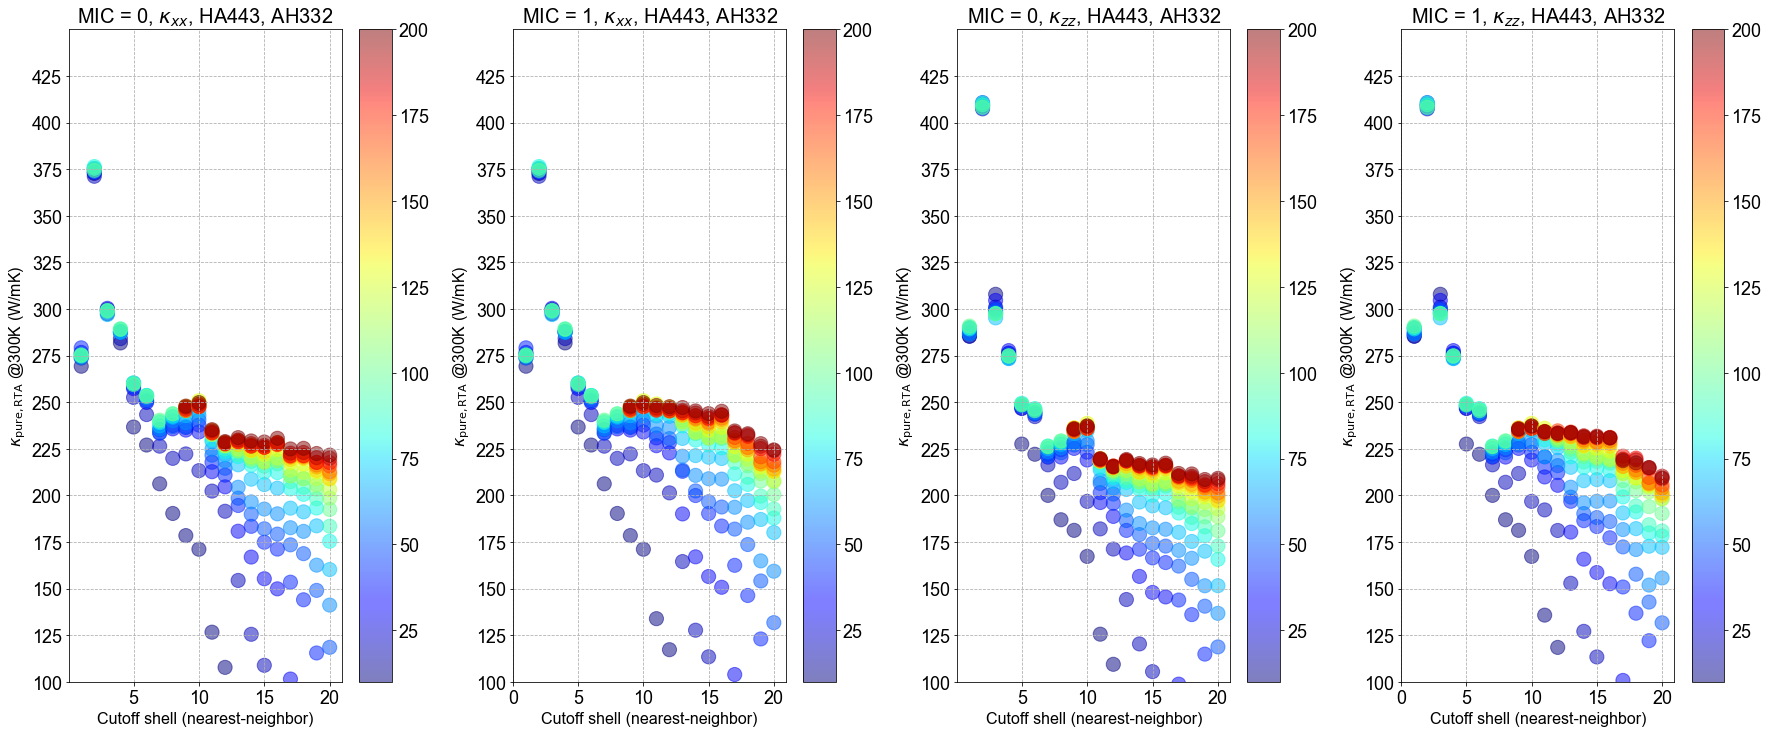

In [469]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(30,12))
nrows = 1
ncols = 4

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3, wspace=0.3)

ax = plt.subplot(gs[0,0])

for nn in nnlist:
    kappa_tmp = kappa_kmesh13.loc[(kappa_kmesh13['nn shell'] == nn) &  (kappa_kmesh13['# disp. patterns.'] <= 200)]
    sc = ax.scatter(x=kappa_tmp['nn shell'], y=kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff shell (nearest-neighbor)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 0, $\kappa_{xx}$, HA443, AH332", fontsize=20)

ax.set_ylim(100,450)
ax.set_yticks(np.arange(100, 450, 25))
ax.grid(True, linestyle='--')
plt.colorbar(sc)

ax = plt.subplot(gs[0,1])

for nn in nnlist:
    
    if nn <= 10:
         kappa_tmp = kappa_kmesh13.loc[(kappa_kmesh13['nn shell'] == nn) & (kappa_kmesh13['# disp. patterns.'] <= 200)]
    else:
        kappa_tmp = kappa_kmesh13_mic1.loc[(kappa_kmesh13_mic1['nn shell'] == nn) & (kappa_kmesh13_mic1['# disp. patterns.'] <= 200)]
        
    sc = ax.scatter(x=kappa_tmp['nn shell'], y=kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff shell (nearest-neighbor)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 1, $\kappa_{xx}$, HA443, AH332", fontsize=20)

ax.set_ylim(100,450)
ax.set_xlim(0)
ax.set_yticks(np.arange(100, 450, 25))
#ax.axhline(y=250, linestyle=':')
ax.grid(True, linestyle='--')
#ax.legend(loc='best', fontsize=16)

plt.colorbar(sc)



ax = plt.subplot(gs[0,2])

for nn in nnlist:
    kappa_tmp = kappa_kmesh13.loc[(kappa_kmesh13['nn shell'] == nn) &  (kappa_kmesh13['# disp. patterns.'] <= 200)]
    sc = ax.scatter(x=kappa_tmp['nn shell'], y=kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff shell (nearest-neighbor)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 0, $\kappa_{zz}$, HA443, AH332", fontsize=20)

ax.set_ylim(100,450)
ax.set_yticks(np.arange(100, 450, 25))
ax.grid(True, linestyle='--')
plt.colorbar(sc)

ax = plt.subplot(gs[0,3])

for nn in nnlist:
    
    if nn <= 10:
         kappa_tmp = kappa_kmesh13.loc[(kappa_kmesh13['nn shell'] == nn) & (kappa_kmesh13['# disp. patterns.'] <= 200)]
    else:
        kappa_tmp = kappa_kmesh13_mic1.loc[(kappa_kmesh13_mic1['nn shell'] == nn) & (kappa_kmesh13_mic1['# disp. patterns.'] <= 200)]
        
    sc = ax.scatter(x=kappa_tmp['nn shell'], y=kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff shell (nearest-neighbor)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 1, $\kappa_{zz}$, HA443, AH332", fontsize=20)

ax.set_ylim(100,450)
ax.set_xlim(0)
ax.set_yticks(np.arange(100, 450, 25))
#ax.axhline(y=250, linestyle=':')
ax.grid(True, linestyle='--')
#ax.legend(loc='best', fontsize=16)

plt.colorbar(sc)

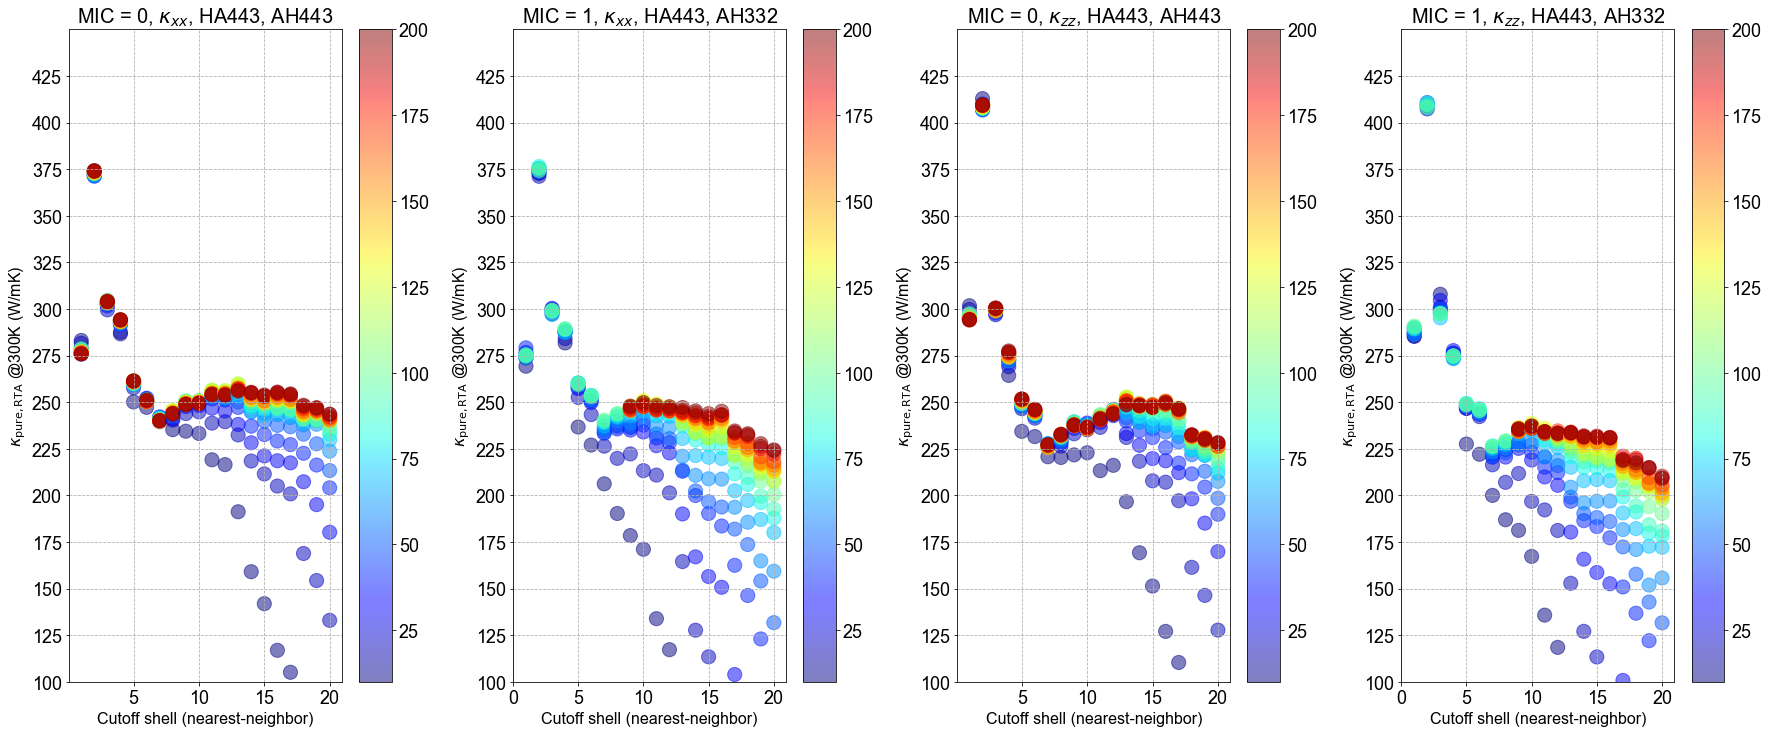

In [472]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(30,12))
nrows = 1
ncols = 4

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3, wspace=0.3)

ax = plt.subplot(gs[0,0])

for nn in nnlist:
    kappa_tmp = kappa_kmesh13_sc443.loc[kappa_kmesh13_sc443['nn shell'] == nn]
    sc = ax.scatter(x=kappa_tmp['nn shell'], y=kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff shell (nearest-neighbor)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 0, $\kappa_{xx}$, HA443, AH443", fontsize=20)

ax.set_ylim(100,450)
ax.set_yticks(np.arange(100, 450, 25))
ax.grid(True, linestyle='--')
plt.colorbar(sc)

ax = plt.subplot(gs[0,1])

for nn in nnlist:
    
    if nn <= 10:
         kappa_tmp = kappa_kmesh13.loc[(kappa_kmesh13['nn shell'] == nn) & (kappa_kmesh13['# disp. patterns.'] <= 200)]
    else:
        kappa_tmp = kappa_kmesh13_mic1.loc[(kappa_kmesh13_mic1['nn shell'] == nn) & (kappa_kmesh13_mic1['# disp. patterns.'] <= 200)]
        
    sc = ax.scatter(x=kappa_tmp['nn shell'], y=kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff shell (nearest-neighbor)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 1, $\kappa_{xx}$, HA443, AH332", fontsize=20)
ax.set_ylim(100,450)
ax.set_xlim(0)
ax.set_yticks(np.arange(100, 450, 25))
#ax.axhline(y=250, linestyle=':')
ax.grid(True, linestyle='--')
#ax.legend(loc='best', fontsize=16)

plt.colorbar(sc)


ax = plt.subplot(gs[0,2])

for nn in nnlist:
    kappa_tmp = kappa_kmesh13_sc443.loc[kappa_kmesh13_sc443['nn shell'] == nn]
    sc = ax.scatter(x=kappa_tmp['nn shell'], y=kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff shell (nearest-neighbor)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 0, $\kappa_{zz}$, HA443, AH443", fontsize=20)

ax.set_ylim(100,450)
ax.set_yticks(np.arange(100, 450, 25))
ax.grid(True, linestyle='--')
plt.colorbar(sc)

ax = plt.subplot(gs[0,3])

for nn in nnlist:
    
    if nn <= 10:
         kappa_tmp = kappa_kmesh13.loc[(kappa_kmesh13['nn shell'] == nn) & (kappa_kmesh13['# disp. patterns.'] <= 200)]
    else:
        kappa_tmp = kappa_kmesh13_mic1.loc[(kappa_kmesh13_mic1['nn shell'] == nn) & (kappa_kmesh13_mic1['# disp. patterns.'] <= 200)]
        
    sc = ax.scatter(x=kappa_tmp['nn shell'], y=kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff shell (nearest-neighbor)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 1, $\kappa_{zz}$, HA443, AH332", fontsize=20)
ax.set_ylim(100,450)
ax.set_xlim(0)
ax.set_yticks(np.arange(100, 450, 25))
#ax.axhline(y=250, linestyle=':')
ax.grid(True, linestyle='--')
#ax.legend(loc='best', fontsize=16)

plt.colorbar(sc)

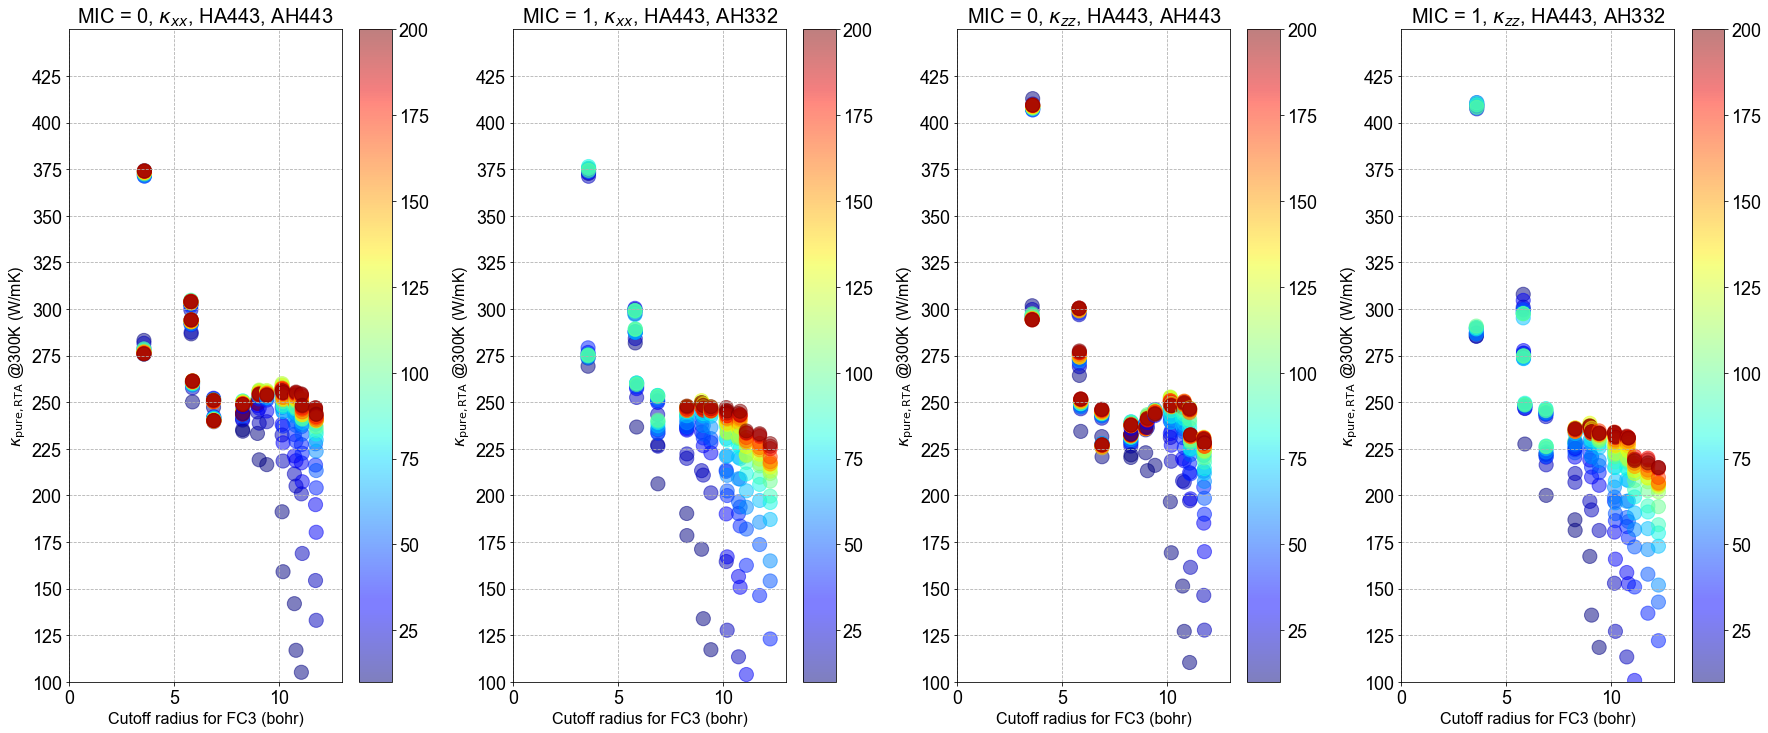

In [473]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(30,12))
nrows = 1
ncols = 4

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3, wspace=0.3)

ax = plt.subplot(gs[0,0])

for nn in nnlist:
    kappa_tmp = kappa_kmesh13_sc443.loc[kappa_kmesh13_sc443['nn shell'] == nn]
    sc = ax.scatter(x=kappa_tmp['Cutoff radius for IFC3 (bohr)'], y=kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff radius for FC3 (bohr)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 0, $\kappa_{xx}$, HA443, AH443", fontsize=20)

ax.set_ylim(100,450)
ax.set_xlim(0, 13)
ax.set_yticks(np.arange(100, 450, 25))
ax.grid(True, linestyle='--')
plt.colorbar(sc)

ax = plt.subplot(gs[0,1])

for nn in nnlist:
    
    if nn <= 10:
         kappa_tmp = kappa_kmesh13.loc[(kappa_kmesh13['nn shell'] == nn) & (kappa_kmesh13['# disp. patterns.'] <= 200)]
    else:
        kappa_tmp = kappa_kmesh13_mic1.loc[(kappa_kmesh13_mic1['nn shell'] == nn) & (kappa_kmesh13_mic1['# disp. patterns.'] <= 200)]
        
    sc = ax.scatter(x=kappa_tmp['Cutoff radius for IFC3 (bohr)'], y=kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff radius for FC3 (bohr)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 1, $\kappa_{xx}$, HA443, AH332", fontsize=20)

ax.set_ylim(100,450)
ax.set_xlim(0, 13)

ax.set_yticks(np.arange(100, 450, 25))
#ax.axhline(y=250, linestyle=':')
ax.grid(True, linestyle='--')
#ax.legend(loc='best', fontsize=16)

plt.colorbar(sc)


ax = plt.subplot(gs[0,2])

for nn in nnlist:
    kappa_tmp = kappa_kmesh13_sc443.loc[kappa_kmesh13_sc443['nn shell'] == nn]
    sc = ax.scatter(x=kappa_tmp['Cutoff radius for IFC3 (bohr)'], y=kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff radius for FC3 (bohr)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 0, $\kappa_{zz}$, HA443, AH443", fontsize=20)

ax.set_ylim(100,450)
ax.set_xlim(0, 13)
ax.set_yticks(np.arange(100, 450, 25))
ax.grid(True, linestyle='--')
plt.colorbar(sc)

ax = plt.subplot(gs[0,3])

for nn in nnlist:
    
    if nn <= 10:
         kappa_tmp = kappa_kmesh13.loc[(kappa_kmesh13['nn shell'] == nn) & (kappa_kmesh13['# disp. patterns.'] <= 200)]
    else:
        kappa_tmp = kappa_kmesh13_mic1.loc[(kappa_kmesh13_mic1['nn shell'] == nn) & (kappa_kmesh13_mic1['# disp. patterns.'] <= 200)]
        
    sc = ax.scatter(x=kappa_tmp['Cutoff radius for IFC3 (bohr)'], y=kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], c=kappa_tmp['# disp. patterns.'], 
               vmin=10, vmax=200, cmap=cm.jet, s=200, alpha=0.5)

ax.set_xlabel("Cutoff radius for FC3 (bohr)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_title("MIC = 1, $\kappa_{zz}$, HA443, AH332", fontsize=20)

ax.set_ylim(100,450)
ax.set_xlim(0, 13)

ax.set_yticks(np.arange(100, 450, 25))
#ax.axhline(y=250, linestyle=':')
ax.grid(True, linestyle='--')
#ax.legend(loc='best', fontsize=16)

plt.colorbar(sc)

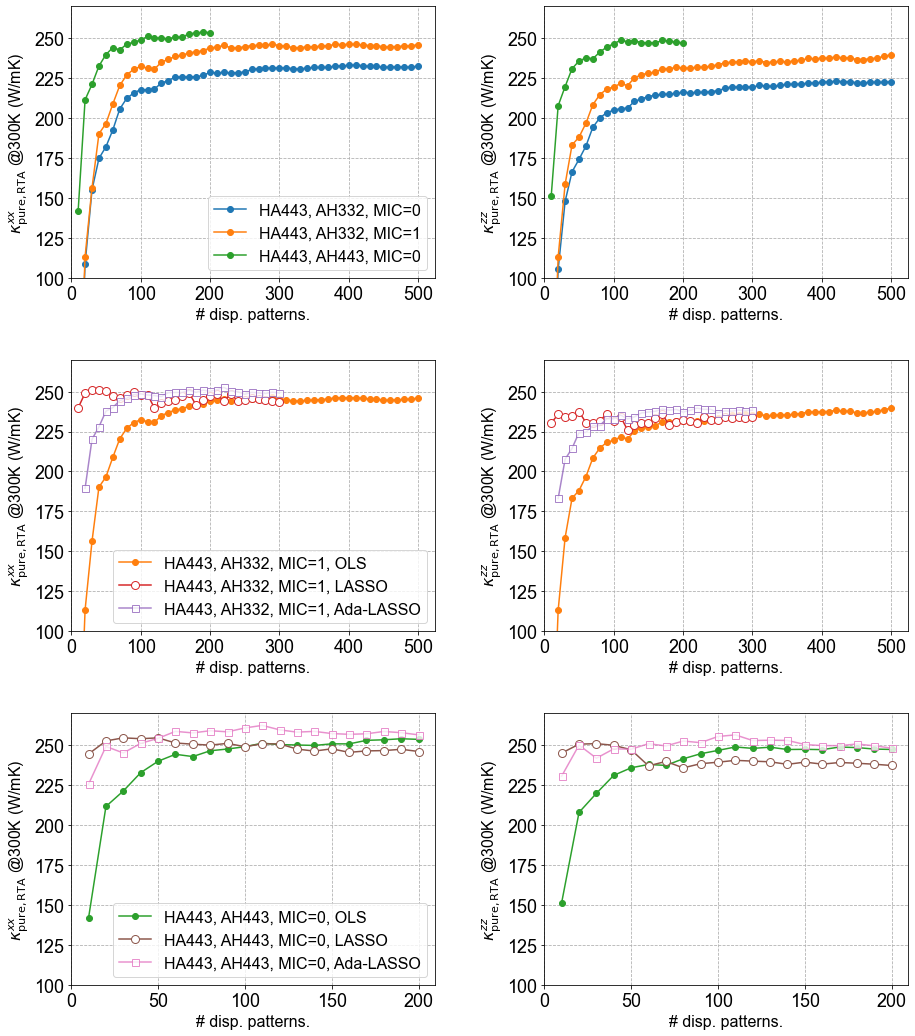

In [597]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(15,18))
nrows = 3
ncols = 2

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3, wspace=0.3)

ax = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

nn = 15

kappa_tmp = kappa_kmesh13.loc[kappa_kmesh13['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', label='HA443, AH332, MIC=0')
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='o', label='HA443, AH332, MIC=0')

kappa_tmp = kappa_kmesh13_mic1.loc[kappa_kmesh13_mic1['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', label='HA443, AH332, MIC=1')
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='o', label='HA443, AH332, MIC=1')

kappa_tmp = kappa_kmesh13_sc443.loc[kappa_kmesh13_sc443['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', label='HA443, AH443, MIC=0')
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='o', label='HA443, AH443, MIC=0')

ax.set_xlabel("# disp. patterns.", fontsize=16)
ax2.set_xlabel("# disp. patterns.", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}^{xx}$ @300K (W/mK)", fontsize=16)
ax2.set_ylabel("$\kappa_{\mathrm{pure,RTA}}^{zz}$ @300K (W/mK)", fontsize=16)

#ax.set_title("MIC = 0, $\kappa_{xx}$, HA443, AH443", fontsize=20)

ax.set_ylim(100,270)
ax2.set_ylim(100,270)
ax.set_xlim(0)
ax2.set_xlim(0)

#ax.set_yticks(np.arange(100, 450, 25))
ax.grid(True, linestyle='--')
ax2.grid(True, linestyle='--')

ax.legend(loc='best', fontsize=16)


ax = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[1,1])

nn = 15

kappa_tmp = kappa_kmesh13_mic1.loc[kappa_kmesh13_mic1['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', label='HA443, AH332, MIC=1, OLS', color='C1')
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='o', label='HA443, AH332, MIC=1, OLS', color='C1')

kappa_tmp = kappa_kmesh13_lasso_mic1.loc[kappa_kmesh13_lasso_mic1['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', ms=8, label='HA443, AH332, MIC=1, LASSO', color='C3',  mfc='white')
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='o', ms=8,label='HA443, AH332, MIC=1, LASSO', color='C3', mfc='white')

kappa_tmp = kappa_kmesh13_adalasso_mic1.loc[kappa_kmesh13_adalasso_mic1['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='s',ms=7, label='HA443, AH332, MIC=1, Ada-LASSO', color='C4', mfc='white',alpha=0.8)
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='s', ms=7,label='HA443, AH332, MIC=1, Ada-LASSO', color='C4', mfc='white',alpha=0.8)


ax.set_xlabel("# disp. patterns.", fontsize=16)
ax2.set_xlabel("# disp. patterns.", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}^{xx}$ @300K (W/mK)", fontsize=16)
ax2.set_ylabel("$\kappa_{\mathrm{pure,RTA}}^{zz}$ @300K (W/mK)", fontsize=16)

ax.set_ylim(100,270)
ax2.set_ylim(100,270)
ax.set_xlim(0)
ax2.set_xlim(0)

ax.grid(True, linestyle='--')
ax2.grid(True, linestyle='--')

ax.legend(loc='best', fontsize=16)


ax = plt.subplot(gs[2,0])
ax2 = plt.subplot(gs[2,1])

nn = 15

kappa_tmp = kappa_kmesh13_sc443.loc[kappa_kmesh13_sc443['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', label='HA443, AH443, MIC=0, OLS', color='C2')
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='o', label='HA443, AH443, MIC=0, OLS', color='C2')

kappa_tmp = kappa_kmesh13_sc443_lasso.loc[kappa_kmesh13_sc443_lasso['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', ms=8, label='HA443, AH443, MIC=0, LASSO', color='C5',  mfc='white')
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='o', ms=8,label='HA443, AH443, MIC=0, LASSO', color='C5', mfc='white')

kappa_tmp = kappa_kmesh13_sc443_adalasso.loc[kappa_kmesh13_sc443_adalasso['nn shell'] == nn]
ax.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{xx} (W/mK)'], marker='s',ms=7, label='HA443, AH443, MIC=0, Ada-LASSO', color='C6', mfc='white',alpha=0.8)
ax2.plot(kappa_tmp['# disp. patterns.'],kappa_tmp['kappa_{RTA,pure}^{zz} (W/mK)'], marker='s', ms=7,label='HA443, AH443, MIC=0, Ada-LASSO', color='C6', mfc='white',alpha=0.8)


ax.set_xlabel("# disp. patterns.", fontsize=16)
ax2.set_xlabel("# disp. patterns.", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}^{xx}$ @300K (W/mK)", fontsize=16)
ax2.set_ylabel("$\kappa_{\mathrm{pure,RTA}}^{zz}$ @300K (W/mK)", fontsize=16)

ax.set_ylim(100,270)
ax2.set_ylim(100,270)
ax.set_xlim(0)
ax2.set_xlim(0)

ax.grid(True, linestyle='--')
ax2.grid(True, linestyle='--')

ax.legend(loc='best', fontsize=16)


## 4.2 Anharmonic - convergence w.r.t. q mesh

The convergence of $\kappa_{L}$ with respect to the q point density was examined using the following computational conditions:

- 4x4x3 supercell for second-order and third-order IFCs
- RTA
- No isotope scattering

In [696]:
temperatures = [20, 300]

nnlist = [15]
rcvals = [10.7303]

kappa_kmesh_conv_sc443 = []

sc_size_ifc2 = '443'
sc_size_ifc3 = '443'
ntraining = 200
rcinfo1 = np.loadtxt('4.Anharmonic/super443.displace/ols/nninfo.txt', usecols=[1,])

for i, nn in enumerate(nnlist):
    for kmesh in [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]:
        nk1 = kmesh
        nk3 = int(kmesh / 1.6 + 0.5)
        qmesh = "%dx%dx%d" % (nk1, nk1, nk3)
        fname1 = '4.Anharmonic/super443.displace/ols/cubic_%dnn_ndata%d_ols_kmesh%d.kl' % (nn, ntraining, nk1)

        if os.path.exists(fname1):
            for temperature in temperatures:
                kappa_tmp1 = get_kappa_from_file(fname1, temperature)
                rcval = rcvals[i]

                kappa_kmesh_conv_sc443.append([sc_size_ifc2, 
                                               sc_size_ifc3, 
                                               rcval,
                                               nn,
                                               ntraining,
                                               temperature,
                                               kappa_tmp1[0],
                                               kappa_tmp1[1],
                                               qmesh,
                                               nk1**2*nk3, None, None])
                
                
for i, nn in enumerate(nnlist):
    for kmesh in range(13, 81, 4):
        nk1 = kmesh
        nk3 = int(kmesh / 1.6 + 0.5)
        if nk3 % 2 == 0:
            nk3 += 1
        qmesh = "%dx%dx%d" % (nk1, nk1, nk3)
        fname1 = '4.Anharmonic/super443.displace/ols/cubic_%dnn_ndata%d_ols_kmesh%d_new.kl' % (nn, ntraining, nk1)
        fname2 = '4.Anharmonic/super443.displace/lasso/cubic_%dnn_ndata%d_adalasso_kmesh%d.kl' % (nn, 50, nk1)
        
        if os.path.exists(fname1) and os.path.exists(fname2):
            for temperature in temperatures:
                kappa_tmp1 = get_kappa_from_file(fname1, temperature)
                kappa_tmp2 = get_kappa_from_file(fname2, temperature)

                rcval = rcvals[i]

                kappa_kmesh_conv_sc443.append([sc_size_ifc2, 
                                               sc_size_ifc3, 
                                               rcval,
                                               nn,
                                               ntraining,
                                               temperature,
                                               kappa_tmp1[0],
                                               kappa_tmp1[1],
                                               qmesh,
                                               nk1**2*nk3, 
                                               kappa_tmp2[0],
                                               kappa_tmp2[1]])

        elif os.path.exists(fname1):
            for temperature in temperatures:
                kappa_tmp1 = get_kappa_from_file(fname1, temperature)
                rcval = rcvals[i]

                kappa_kmesh_conv_sc443.append([sc_size_ifc2, 
                                               sc_size_ifc3, 
                                               rcval,
                                               nn,
                                               ntraining,
                                               temperature,
                                               kappa_tmp1[0],
                                               kappa_tmp1[1],
                                               qmesh,
                                               nk1**2*nk3,
                                               None,
                                               None])

                
kappa_kmesh_conv_sc443 = pd.DataFrame(kappa_kmesh_conv_sc443,
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  'Temperature (K)', 
                                  'kappa_{RTA,pure}^{xx} (W/mK)',
                                  'kappa_{RTA,pure}^{zz} (W/mK)',
                                  'qmesh',
                                  'qpoints', 
                                  'kappa_{adalasso}^{xx} (W/mK)',
                                  'kappa_{adalasso}^{zz} (W/mK)']).sort_values(by=['SC size IFC2', 
                                                                            'SC size IFC3'])

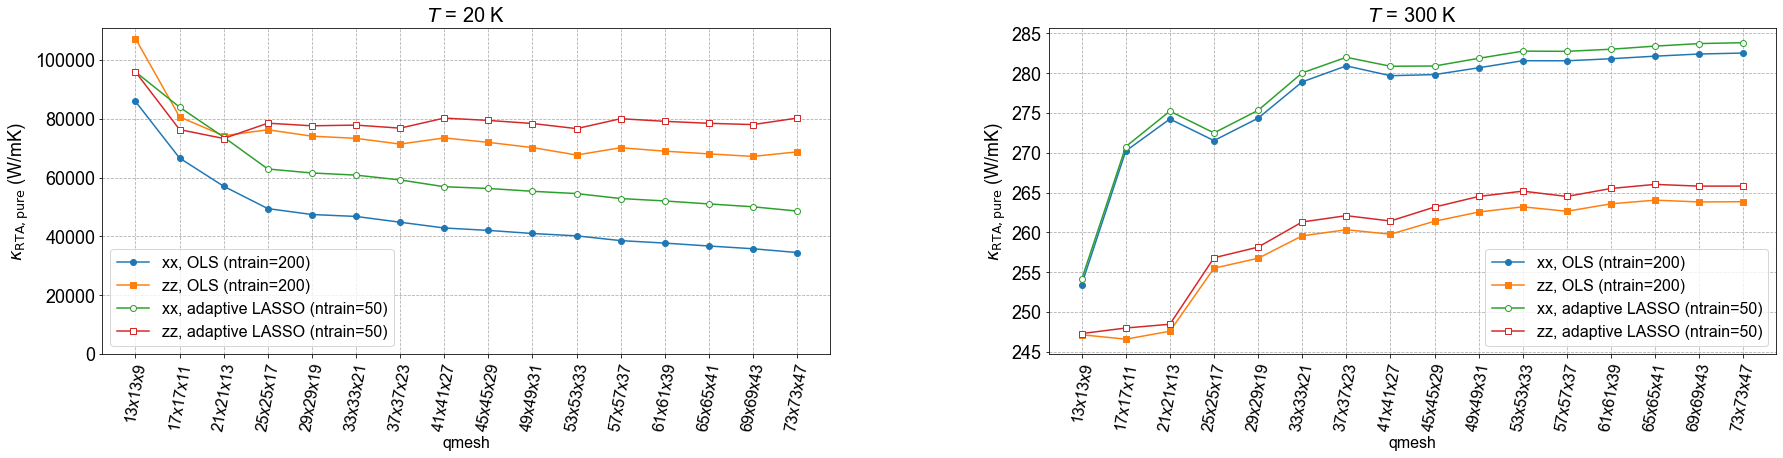

In [752]:
fig = plt.figure(figsize=(30,6))
nrows = 1
ncols = 2

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3, wspace=0.3)

ax = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

nn = 15

kappa_tmp = kappa_kmesh_conv_sc443.loc[(kappa_kmesh_conv_sc443['nn shell'] == nn) &  (kappa_kmesh_conv_sc443['kappa_{adalasso}^{xx} (W/mK)'].notnull())]

# 20 K
kappa_tmp2 = kappa_tmp.loc[(kappa_tmp['Temperature (K)'] == 20)].sort_values(by='qpoints')
ax.plot(kappa_tmp2['qmesh'],kappa_tmp2['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', label='xx, OLS (ntrain=200)')
ax.plot(kappa_tmp2['qmesh'],kappa_tmp2['kappa_{RTA,pure}^{zz} (W/mK)'], marker='s', label='zz, OLS (ntrain=200)')
ax.plot(kappa_tmp2['qmesh'],kappa_tmp2['kappa_{adalasso}^{xx} (W/mK)'], marker='o', label='xx, adaptive LASSO (ntrain=50)', mfc='white')
ax.plot(kappa_tmp2['qmesh'],kappa_tmp2['kappa_{adalasso}^{zz} (W/mK)'], marker='s', label='zz, adaptive LASSO (ntrain=50)', mfc='white')

ax.set_xlabel("qmesh", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{RTA,pure}}$ (W/mK)", fontsize=18)
ax.set_xticklabels(kappa_tmp2['qmesh'], rotation = 80, fontsize=16)
ax.set_title("$T$ = 20 K", fontsize=20)
ax.grid(True, linestyle='--')
ax.legend(loc='best', fontsize=16)
ax.set_ylim(0)


# 300 K
kappa_tmp2 = kappa_tmp.loc[kappa_tmp['Temperature (K)'] == 300].sort_values(by='qpoints')
ax2.plot(kappa_tmp2['qmesh'],kappa_tmp2['kappa_{RTA,pure}^{xx} (W/mK)'], marker='o', label='xx, OLS (ntrain=200)')
ax2.plot(kappa_tmp2['qmesh'],kappa_tmp2['kappa_{RTA,pure}^{zz} (W/mK)'], marker='s', label='zz, OLS (ntrain=200)')
ax2.plot(kappa_tmp2['qmesh'],kappa_tmp2['kappa_{adalasso}^{xx} (W/mK)'], marker='o', label='xx, adaptive LASSO (ntrain=50)', mfc='white')
ax2.plot(kappa_tmp2['qmesh'],kappa_tmp2['kappa_{adalasso}^{zz} (W/mK)'], marker='s', label='zz, adaptive LASSO (ntrain=50)', mfc='white')
ax2.set_xlabel("qmesh", fontsize=16)
ax2.set_ylabel("$\kappa_{\mathrm{RTA,pure}}$ (W/mK)", fontsize=18)
ax2.set_xticklabels(kappa_tmp2['qmesh'], rotation = 80, fontsize=16)
ax2.set_title("$T$ = 300 K", fontsize=20)
ax2.grid(True, linestyle='--')
ax2.legend(loc='best', fontsize=16)


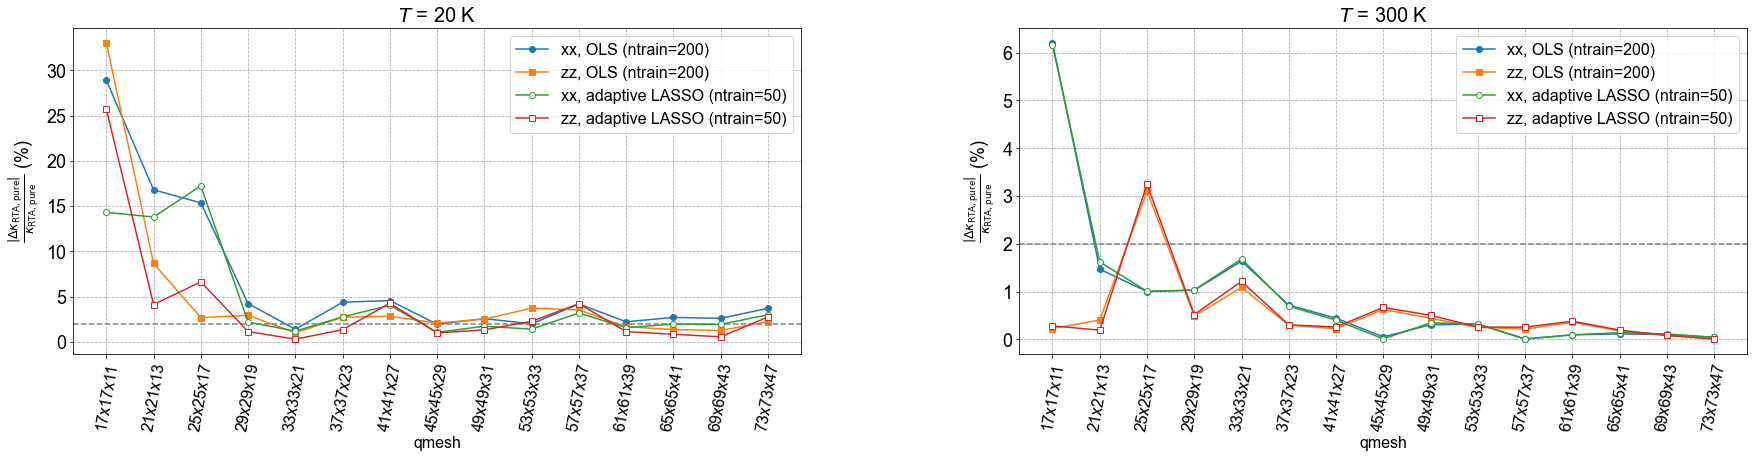

In [775]:
fig = plt.figure(figsize=(30,6))
nrows = 1
ncols = 2

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3, wspace=0.3)

ax = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

nn = 15

kappa_tmp = kappa_kmesh_conv_sc443.loc[(kappa_kmesh_conv_sc443['nn shell'] == nn) &  (kappa_kmesh_conv_sc443['kappa_{adalasso}^{xx} (W/mK)'].notnull())]

# 20 K
kappa_tmp2 = kappa_tmp.loc[(kappa_tmp['Temperature (K)'] == 20)].sort_values(by='qpoints')
ax.plot(kappa_tmp2['qmesh'],abs(kappa_tmp2['kappa_{RTA,pure}^{xx} (W/mK)'].diff())/kappa_tmp2['kappa_{RTA,pure}^{xx} (W/mK)']*100, marker='o', label='xx, OLS (ntrain=200)')
ax.plot(kappa_tmp2['qmesh'],abs(kappa_tmp2['kappa_{RTA,pure}^{zz} (W/mK)'].diff())/kappa_tmp2['kappa_{RTA,pure}^{zz} (W/mK)']*100, marker='s', label='zz, OLS (ntrain=200)')
ax.axhline(y=2,linestyle='--',color='gray')
ax.plot(kappa_tmp2['qmesh'],abs(kappa_tmp2['kappa_{adalasso}^{xx} (W/mK)'].diff())/kappa_tmp2['kappa_{adalasso}^{xx} (W/mK)']*100, marker='o', label='xx, adaptive LASSO (ntrain=50)', mfc='white')
ax.plot(kappa_tmp2['qmesh'],abs(kappa_tmp2['kappa_{adalasso}^{zz} (W/mK)'].diff())/kappa_tmp2['kappa_{adalasso}^{zz} (W/mK)']*100, marker='s', label='zz, adaptive LASSO (ntrain=50)', mfc='white')

ax.set_xlabel("qmesh", fontsize=16)
ax.set_ylabel(r"$ \frac{|\Delta \kappa_{\mathrm{RTA,pure}}|}{\kappa_{\mathrm{RTA,pure}}}$ (%)", fontsize=18)
ax.set_xticklabels(kappa_tmp2['qmesh'], rotation = 80, fontsize=16)
ax.set_title("$T$ = 20 K", fontsize=20)
ax.grid(True, linestyle='--')
ax.legend(loc='best', fontsize=16)
#ax.set_ylim(0)


# 300 K
kappa_tmp2 = kappa_tmp.loc[kappa_tmp['Temperature (K)'] == 300].sort_values(by='qpoints')
ax2.plot(kappa_tmp2['qmesh'],abs(kappa_tmp2['kappa_{RTA,pure}^{xx} (W/mK)'].diff())/kappa_tmp2['kappa_{RTA,pure}^{xx} (W/mK)']*100, marker='o', label='xx, OLS (ntrain=200)')
ax2.plot(kappa_tmp2['qmesh'],abs(kappa_tmp2['kappa_{RTA,pure}^{zz} (W/mK)'].diff())/kappa_tmp2['kappa_{RTA,pure}^{zz} (W/mK)']*100, marker='s', label='zz, OLS (ntrain=200)')
ax2.axhline(y=2,linestyle='--',color='gray')
ax2.plot(kappa_tmp2['qmesh'],abs(kappa_tmp2['kappa_{adalasso}^{xx} (W/mK)'].diff())/kappa_tmp2['kappa_{adalasso}^{xx} (W/mK)']*100, marker='o', label='xx, adaptive LASSO (ntrain=50)', mfc='white')
ax2.plot(kappa_tmp2['qmesh'],abs(kappa_tmp2['kappa_{adalasso}^{zz} (W/mK)'].diff())/kappa_tmp2['kappa_{adalasso}^{zz} (W/mK)']*100, marker='s', label='zz, adaptive LASSO (ntrain=50)', mfc='white')
ax2.set_xlabel("qmesh", fontsize=16)
ax2.set_ylabel(r"$ \frac{|\Delta \kappa_{\mathrm{RTA,pure}}|}{\kappa_{\mathrm{RTA,pure}}}$ (%)", fontsize=18)
ax2.set_xticklabels(kappa_tmp2['qmesh'], rotation = 80, fontsize=16)
ax2.set_title("$T$ = 300 K", fontsize=20)
ax2.grid(True, linestyle='--')
ax2.legend(loc='best', fontsize=16)


## 4. Anharmonic - production run

After checking the convergence of kappa w.r.t. various parameters, I have chosen the following set of parameters for the production calculation.

- Lattice constant (Ang.) : a = 3.1135, c = 4.9831
- ENCUT = 550
- SC for IFC2: `443`
- SC for IFC3: `443`
- Cutoff radius for IFC3 (bohr): 10.74 (includes up to 15NN shells)
- 55x55x33 q points
- tetrahedron method for delta function
- Mass of Al : 26.9815384 au
- Mass of N : 14.003074 au
- temperature step: 10 K

The results of the production calculation are shown in the following tables/figures.

In [888]:
#load data of production run

kl_pure = np.loadtxt('4.Anharmonic/super443.displace/ols/cubic_15nn_ndata200_ols_kmesh53_new.kl', usecols=[0, 1, 5, 9])
kl_pure2 = np.loadtxt('4.Anharmonic/super443.displace/ols/cubic_15nn_ndata200_ols_kmesh53_dense.kl', usecols=[0, 1, 5, 9])

kl_pure_spec = np.loadtxt('4.Anharmonic/super443.displace/ols/cubic_15nn_ndata200_ols_kmesh53_new.kl_spec')

target_temperatures = np.concatenate((np.arange(20, 50, 10),
                                      np.arange(50, 301, 20),
                                      np.arange(300, 1001, 100)))

kl_production = pd.DataFrame(kl_pure, columns=['Temperature (K)', 'RTA, xx', 'RTA, yy', 'RTA, zz'])
kl_production = kl_production[kl_production['Temperature (K)'].isin(target_temperatures)]

# kl_production_sub = pd.DataFrame(kl_pure2, columns=['Temperature (K)', 'RTA, xx', 'RTA, yy', 'RTA, zz'])
# kl_production_sub = kl_production_sub[kl_production_sub['Temperature (K)'].isin(np.arange(50, 301, 25))]

# print(kl_production_sub)


kl_pure_spec = pd.read_table('4.Anharmonic/super443.displace/ols/cubic_15nn_ndata200_ols_kmesh53_new.kl_spec', comment='#',
                             header=None, names=['Temperature (K)', 'Omega (cm^-1)', 
                                                 'kappa spec xx', 
                                                 'kappa spec yy', 
                                                 'kappa spec zz'],
                             delim_whitespace=True, usecols=[0, 1, 2, 3, 4])


kl_pure_spec['Omega (cm^-1)'] *= kayser_to_THz
kl_pure_spec['kappa spec xx'] /= kayser_to_THz
kl_pure_spec['kappa spec yy'] /= kayser_to_THz
kl_pure_spec['kappa spec zz'] /=  kayser_to_THz
kl_pure_spec.rename(columns={'Omega (cm^-1)': 'Frequency (THz)', 
                             'kappa spec xx' : 'kappa spec xx (W/mK/THz)', 
                             'kappa spec yy' : 'kappa spec yy (W/mK/THz)', 
                             'kappa spec zz' : 'kappa spec zz (W/mK/THz)' }, inplace=True)

In [802]:
kl_accum_x = pd.read_table('4.Anharmonic/super443.displace/ols/cumulative_x_20K.dat', comment='#',
                              header=None, names=['mfp (nm)', 'cumulative kappa xx (W/mK)'],
                              delim_whitespace=True, usecols=[0, 1])

kl_accum_y = pd.read_table('4.Anharmonic/super443.displace/ols/cumulative_y_20K.dat', comment='#',
                              header=None, names=['cumulative kappa yy (W/mK)'],
                              delim_whitespace=True, usecols=[5,])

kl_accum_z = pd.read_table('4.Anharmonic/super443.displace/ols/cumulative_z_20K.dat', comment='#',
                              header=None, names=['cumulative kappa zz (W/mK)'],
                              delim_whitespace=True, usecols=[9,])

kl_accum_20 = pd.concat([kl_accum_x, kl_accum_y, kl_accum_z], axis=1)


kl_accum_x = pd.read_table('4.Anharmonic/super443.displace/ols/cumulative_x_300K.dat', comment='#',
                              header=None, names=['mfp (nm)', 'cumulative kappa xx (W/mK)'],
                              delim_whitespace=True, usecols=[0, 1])

kl_accum_y = pd.read_table('4.Anharmonic/super443.displace/ols/cumulative_y_300K.dat', comment='#',
                              header=None, names=['cumulative kappa yy (W/mK)'],
                              delim_whitespace=True, usecols=[5,])

kl_accum_z = pd.read_table('4.Anharmonic/super443.displace/ols/cumulative_z_300K.dat', comment='#',
                              header=None, names=['cumulative kappa zz (W/mK)'],
                              delim_whitespace=True, usecols=[9,])

kl_accum_300 = pd.concat([kl_accum_x, kl_accum_y, kl_accum_z], axis=1)

In [863]:
mode_contribution_300 = pd.read_table('4.Anharmonic/super443.displace/ols/tau300K_kmesh53.dat', comment='#',
                                      header=None, 
                                      names=['k index (irred.)', 'branch index', 'f (cm^-1)', 'lifetime (ps)', 'mfp (nm)', 
                                             'multiplicity', 'modal kappa^{xx} (W/mK)', 'modal kappa^{yy} (W/mK)', 'modal kappa^{zz} (W/mK)'],
                                      delim_whitespace=True, usecols=[0, 1, 2, 3, 5, 6, 7, 11, 15])

mode_contribution_20 = pd.read_table('4.Anharmonic/super443.displace/ols/tau20K_kmesh53.dat', comment='#',
                                          header=None, 
                                          names=['k index (irred.)', 'branch index', 'f (cm^-1)', 'lifetime (ps)', 'mfp (nm)', 
                                                 'multiplicity', 'modal kappa^{xx} (W/mK)', 'modal kappa^{yy} (W/mK)', 'modal kappa^{zz} (W/mK)'],
                                          delim_whitespace=True, usecols=[0, 1, 2, 3, 5, 6, 7, 11, 15])

mode_contribution_300['f (cm^-1)'] *= kayser_to_THz
mode_contribution_20['f (cm^-1)'] *= kayser_to_THz

mode_contribution_300.rename(columns={'f (cm^-1)' : 'f (THz)'}, inplace=True)
mode_contribution_20.rename(columns={'f (cm^-1)' : 'f (THz)'}, inplace=True)

scattering_rates_300 = mode_contribution_300.iloc[:,0:3]
scattering_rates_300['1/tau_3ph (THz)'] = 1.0 / mode_contribution_300['lifetime (ps)']
scattering_rates_300.at[0, '1/tau_3ph (THz)'] = 0
scattering_rates_300.at[1, '1/tau_3ph (THz)'] = 0
scattering_rates_300.at[2, '1/tau_3ph (THz)'] = 0

scattering_rates_20 = mode_contribution_20.iloc[:,0:3]
scattering_rates_20['1/tau_3ph (THz)'] = 1.0 / mode_contribution_20['lifetime (ps)']
scattering_rates_20.at[0, '1/tau_3ph (THz)'] = 0
scattering_rates_20.at[1, '1/tau_3ph (THz)'] = 0
scattering_rates_20.at[2, '1/tau_3ph (THz)'] = 0

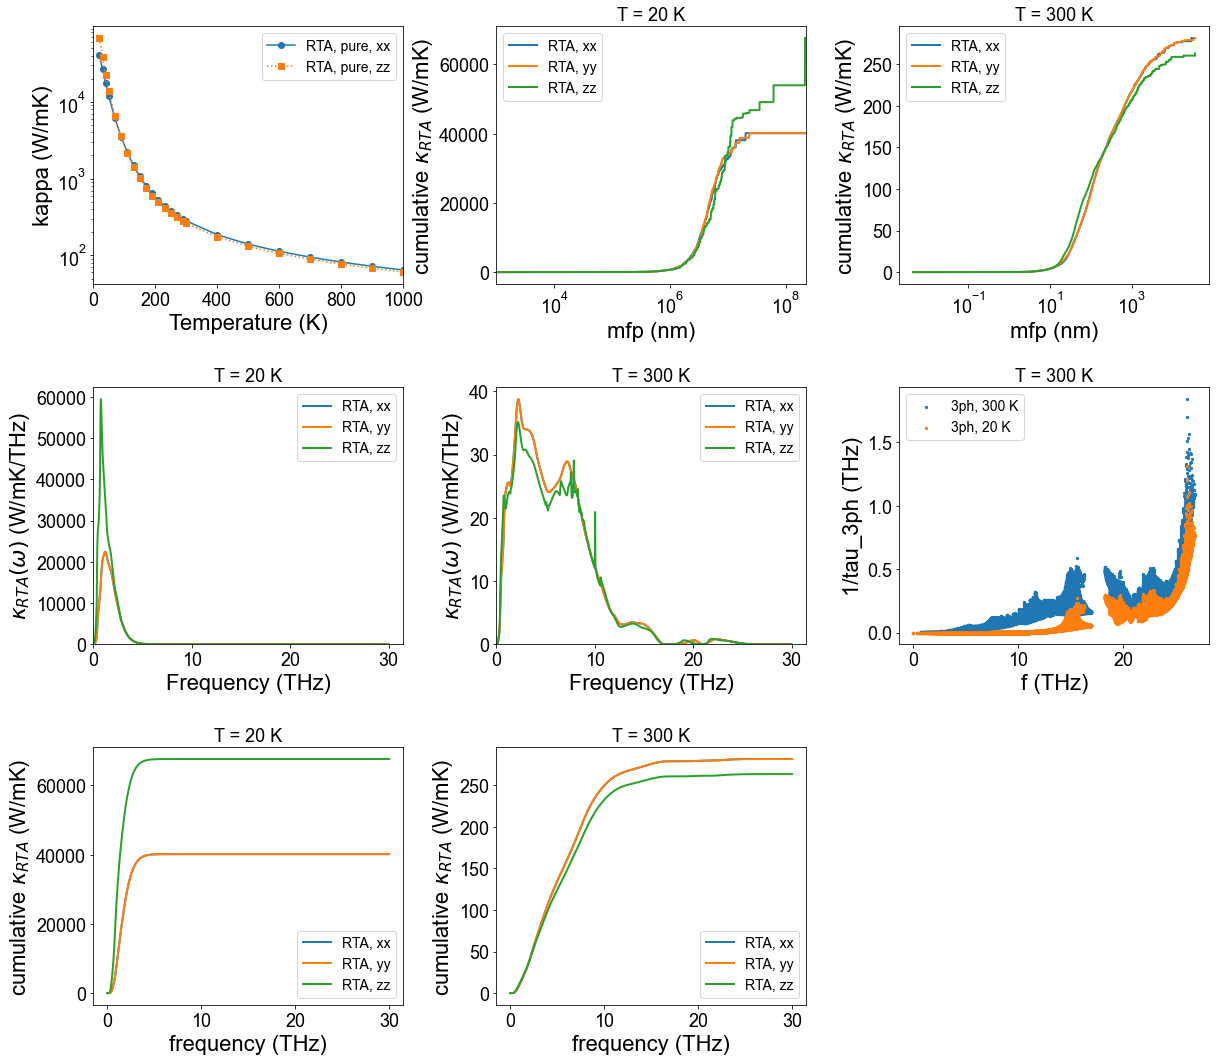

In [841]:
## Plot data

fig = plt.figure(figsize=(20,18))
nrows = 3
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.4, wspace=0.3)

ax = plt.subplot(gs[0])
ax.plot(kl_production['Temperature (K)'], kl_production['RTA, xx'], linestyle='-', marker='o', label='RTA, pure, xx')
ax.plot(kl_production['Temperature (K)'], kl_production['RTA, zz'], linestyle=':', marker='s', label='RTA, pure, zz')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('kappa (W/mK)')
ax.set_yscale('log')
ax.set_xlim(0,1000)
#ax.set_ylim(10,1e+5)
ax.legend(loc='best', fontsize=14)

ax = plt.subplot(gs[1])

kl_accum_20.plot(x=0, y=1, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, label="RTA, xx")
kl_accum_20.plot(x=0, y=2, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, label="RTA, yy")
kl_accum_20.plot(x=0, y=3, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, label="RTA, zz")

ax.set_xlim(10**3)
ax.legend(loc='best', fontsize=14)
ax.set_xscale('log')
ax.set_title('T = 20 K', fontsize=18)


ax = plt.subplot(gs[2])

kl_accum_300.plot(x=0, y=1, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, label="RTA, xx")
kl_accum_300.plot(x=0, y=2, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, label="RTA, yy")
kl_accum_300.plot(x=0, y=3, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, label="RTA, zz")

#ax.set_xlim(10**3)
ax.legend(loc='best', fontsize=14)
ax.set_xscale('log')
ax.set_title('T = 300 K', fontsize=18)

ax = plt.subplot(gs[3])
kl_spec_tmp = kl_pure_spec[kl_pure_spec['Temperature (K)'] == 20]
kl_spec_tmp.plot(x=1, y=2, ax=ax, linewidth=2.0, label="RTA, xx")
kl_spec_tmp.plot(x=1, y=3, ax=ax, linewidth=2.0, label="RTA, yy")
kl_spec_tmp.plot(x=1, y=4, ax=ax, linewidth=2.0, label="RTA, zz", ylabel=r'$\kappa_{RTA}(\omega)$ (W/mK/THz)')

ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 20 K', fontsize=18)

ax = plt.subplot(gs[4])
kl_spec_tmp = kl_pure_spec[kl_pure_spec['Temperature (K)'] == 300]
kl_spec_tmp.plot(x=1, y=2, ax=ax, linewidth=2.0, label="RTA, xx")
kl_spec_tmp.plot(x=1, y=3, ax=ax, linewidth=2.0, label="RTA, yy")
kl_spec_tmp.plot(x=1, y=4, ax=ax, linewidth=2.0, label="RTA, zz", ylabel=r'$\kappa_{RTA}(\omega)$ (W/mK/THz)')
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)

ax = plt.subplot(gs[6])
kl_spec_tmp = kl_pure_spec[kl_pure_spec['Temperature (K)'] == 20]
ax.plot(kl_spec_tmp['Frequency (THz)'], kl_spec_tmp['kappa spec xx (W/mK/THz)'].cumsum()*kayser_to_THz, linewidth=2.0, linestyle='-', label="RTA, xx")
ax.plot(kl_spec_tmp['Frequency (THz)'], kl_spec_tmp['kappa spec yy (W/mK/THz)'].cumsum()*kayser_to_THz, linewidth=2.0, linestyle='-', label="RTA, yy")
ax.plot(kl_spec_tmp['Frequency (THz)'], kl_spec_tmp['kappa spec zz (W/mK/THz)'].cumsum()*kayser_to_THz, linewidth=2.0, linestyle='-', label="RTA, zz")
ax.set_xlabel('frequency (THz)')
ax.set_ylabel(r'cumulative $\kappa_{RTA}$ (W/mK)')
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 20 K', fontsize=18)


ax = plt.subplot(gs[7])
kl_spec_tmp = kl_pure_spec[kl_pure_spec['Temperature (K)'] == 300]
ax.plot(kl_spec_tmp['Frequency (THz)'], kl_spec_tmp['kappa spec xx (W/mK/THz)'].cumsum()*kayser_to_THz, linewidth=2.0, linestyle='-', label="RTA, xx")
ax.plot(kl_spec_tmp['Frequency (THz)'], kl_spec_tmp['kappa spec yy (W/mK/THz)'].cumsum()*kayser_to_THz, linewidth=2.0, linestyle='-', label="RTA, yy")
ax.plot(kl_spec_tmp['Frequency (THz)'], kl_spec_tmp['kappa spec zz (W/mK/THz)'].cumsum()*kayser_to_THz, linewidth=2.0, linestyle='-', label="RTA, zz")
ax.set_xlabel('frequency (THz)')
ax.set_ylabel(r'cumulative $\kappa_{RTA}$ (W/mK)')
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)


ax = plt.subplot(gs[5])
scattering_rates_300.plot(x=2, y=3, ax=ax, kind='scatter', marker='.', label='3ph, 300 K')
scattering_rates_20.plot(x=2, y=3, ax=ax, kind='scatter', marker='.', label='3ph, 20 K', color='C1')

ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)
#ax.set_xlim(0, 12)
#ax.set_ylim(0, 1.0)

plt.savefig('production_kappa.pdf', bbox_inches='tight')
plt.show()

In [913]:
# Write all data to files
from ase.units import Bohr
vasp_encut.to_csv('upload/outputs/1.structure_convergence_encut.txt', index=None, sep=' ', float_format="%.5f")
vasp_kmesh.to_csv('upload/outputs/1.structure_convergence_kmesh.txt', index=None, sep=' ', float_format="%.5f")

# Electronic band structures

labels = ['G-M', 'G-K-M', 'G-A']
scaler_a = np.pi / 3.11354109266049
scaler_c = np.pi / 4.98311595690762
scalers = [scaler_a, scaler_a, scaler_c]

for iax, label in enumerate(labels):
    bs_tmp = bs_k12[100*iax:100*(iax+1)]
    kaxis = (bs_tmp['k_distance']-bs_tmp['k_distance'].iloc[0]) / scalers[iax]
    del bs_tmp['k_distance']
    bs_tmp.insert(0,'kaxis (pi/a or pi/c unit)', kaxis)
    
    filename = 'upload/outputs/2.electronic_band_%s.txt' % label
    with open(filename, 'w') as f:
        f.write("# Efermi (eV) : %f\n" % bs_k12.attrs['efermi'])
        f.write("# %s\n" % bs_k12.attrs['SCF'])
    
    bs_tmp.to_csv(filename, index=None, sep= ' ', mode='a', float_format="%.5f")

    
summary_ph_convcheck_kmesh.to_csv('upload/outputs/3.convergence_frequency_gamma_kmesh.txt', index=None, sep=' ', float_format="%.5f")
summary_ph_convcheck_encut.to_csv('upload/outputs/3.convergence_frequency_gamma_encut.txt', index=None, sep=' ', float_format="%.5f")

# Phonon band structures, DOS

scaler_a = np.pi / (3.11354109266049 / Bohr)
scaler_c = np.pi / (4.98311595690762 / Bohr)
scalers = [scaler_a, scaler_a, scaler_c]

for i, label in enumerate(labels):
    
    filename = 'upload/outputs/3.phonon_band_%s.txt' % label
    with open(filename, 'w') as f:
        f.write("# 4x4x3 supercell\n")
        
    bs_tmp = phband_data[-1][i].copy()
    kaxis = (bs_tmp['q (original)']- bs_tmp['q (original)'].iloc[0]) / scalers[i]
    del bs_tmp['q (original)']
    del bs_tmp['q (normalized)']
    bs_tmp.insert(0,'kaxis (pi/a or pi/c unit)', kaxis)
    bs_tmp.to_csv(filename, index=None, sep=' ', mode='a', float_format="%.5f")


phdos.to_csv('upload/outputs/3.phonon_dos.txt', index=None, sep=' ', float_format="%.5f")
    
    
# Thermal conductivities

filename = 'upload/outputs/4.kappa_temperature_dependence.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")

kl_production.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')


kl_spec_20 = kl_pure_spec[kl_pure_spec['Temperature (K)'] == 20.0]
kl_spec_300 = kl_pure_spec[kl_pure_spec['Temperature (K)'] == 300.0]

del kl_spec_20['Temperature (K)']
del kl_spec_300['Temperature (K)']

kl_spec_20['cumulative kappa xx (W/mK)'] = kl_spec_20['kappa spec xx (W/mK/THz)'].cumsum()*kayser_to_THz
kl_spec_20['cumulative kappa yy (W/mK)'] = kl_spec_20['kappa spec yy (W/mK/THz)'].cumsum()*kayser_to_THz
kl_spec_20['cumulative kappa zz (W/mK)'] = kl_spec_20['kappa spec zz (W/mK/THz)'].cumsum()*kayser_to_THz
kl_spec_300['cumulative kappa xx (W/mK)'] = kl_spec_300['kappa spec xx (W/mK/THz)'].cumsum()*kayser_to_THz
kl_spec_300['cumulative kappa yy (W/mK)'] = kl_spec_300['kappa spec yy (W/mK/THz)'].cumsum()*kayser_to_THz
kl_spec_300['cumulative kappa zz (W/mK)'] = kl_spec_300['kappa spec zz (W/mK/THz)'].cumsum()*kayser_to_THz

filename = 'upload/outputs/4.kappa_20K_cumulative_freq.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 20 K\n")

kl_spec_20.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')

filename = 'upload/outputs/4.kappa_300K_cumulative_freq.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 300 K\n")

kl_spec_300.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')


filename = 'upload/outputs/4.kappa_20K_cumulative_mfp.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 20 K\n")

kl_accum_20.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')


filename = 'upload/outputs/4.kappa_300K_cumulative_mfp.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 300 K\n")

kl_accum_300.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')

filename = 'upload/outputs/4.mfp_and_mode_contribution_300K.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 300 K\n")
    
mode_contribution_300.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')

filename = 'upload/outputs/4.mfp_and_mode_contribution_20K.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 20 K\n")
    
mode_contribution_20.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')

filename = 'upload/outputs/4.scattering_rates_20K.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 20 K\n")
    
scattering_rates_20.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')


filename = 'upload/outputs/4.scattering_rates_300K.txt'
with open(filename, 'w') as f:
    f.write("# 4x4x3 supercell for harmonic, 4x4x3 supercell for cubic ifcs\n")
    f.write("# 53x53x33 k points for kappa\n")
    f.write("# cubic ifcs up to 15NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 300 K\n")
    
scattering_rates_300.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')


In [883]:
# Computational times
import glob

jobs = ['Structure', 'Electrons', 'Harmonic', 'Anharmonic', 'Thermal cond.']
times_convcheck = []
times_production = []

# Structure
times_convcheck.append(vasp_encut['Core Hours'].sum() + vasp_kmesh['Core Hours'].sum())
times_production.append(0)

# ELectronic
time_tmp = get_corehours_vasp('2.Electronic/band/OUTCAR.scf_k12') \
           + get_corehours_vasp('2.Electronic/band/OUTCAR.scf_k20') \
           + get_corehours_vasp('2.Electronic/band/OUTCAR.band_k12') \
           + get_corehours_vasp('2.Electronic/band/OUTCAR.band_k20') 

outcars = glob.glob("2.Electronic/dielec/OUTCAR.ENCUT*")
for outcar in outcars:
    time_tmp += get_corehours_vasp(outcar)
times_convcheck.append(time_tmp)


time_tmp = get_corehours_vasp('2.Electronic/band/OUTCAR.scf_k12') \
           + get_corehours_vasp('2.Electronic/band/OUTCAR.band_k12') 

outcars = glob.glob("2.Electronic/dielec/OUTCAR.ENCUT550.k=12")
for outcar in outcars:
    time_tmp += get_corehours_vasp(outcar)

times_production.append(time_tmp)


# Harmonic
time_tmp = get_nodehour_vasp2('3.Harmonic/convergence_check', "OUTCAR.*")[0] \
                       + get_nodehour_vasp2('3.Harmonic/super222.displace', "OUTCAR.disp*")[0] \
                       + get_nodehour_vasp2('3.Harmonic/super332.displace', "OUTCAR.disp*")[0] \
                       + get_nodehour_vasp2('3.Harmonic/super442.displace', "OUTCAR.disp*")[0] 

time_tmp2 = get_nodehour_vasp2('3.Harmonic/super443.displace', "OUTCAR.disp*")[0] 

times_convcheck.append((time_tmp+time_tmp2)*48)
times_production.append(time_tmp2*48)

# Anharmonic
time_tmp = get_nodehour_vasp2('4.Anharmonic/super332.displace', "OUTCAR.disp*")[0] 
time_tmp2 = get_nodehour_vasp2('4.Anharmonic/super443.displace', "OUTCAR.disp*")[0] 

times_convcheck.append((time_tmp + time_tmp2 * 2.0/3.0)*48)
times_production.append((time_tmp2 * 2.0/3.0)*48) # 300 structures are computed but only 200 were used

In [886]:
# Thermal cond.

time_tmp = 0.0

files = ["/super332.displace/lasso/elapsed_time.dat",
         "/super332.displace/ols/elapsed_time.dat",
         "/super443.displace/lasso/elapsed_time.dat", 
         "/super443.displace/ols/elapsed_time.dat"]

for file in files:
    time_data = np.loadtxt('4.Anharmonic/%s' % file, usecols=[0, 1, 2])
    time_tmp += np.sum(time_data[:,0]*time_data[:,1]*time_data[:,2])/3600


times_convcheck.append(time_tmp)
times_production.append(2304*6359/3600)

filename = 'upload/outputs/core_hours.txt'
with open(filename, 'w') as f:

    f.write('# Summary of CPU time in units of core*hours\n')
    f.write('#         Job, time for conv. check, time for production run\n')
    for i in range(5):
        f.write("%15s %10.1f %10.1f\n" % (jobs[i], times_convcheck[i], times_production[i]))

